In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import re

from scipy import stats
from scipy.special import boxcox, inv_boxcox

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import mutual_info_classif

import time
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import _tree
from sklearn import tree

from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV

from bayes_opt import BayesianOptimization

from sklearn import metrics

import shap

/Users/keithlowton/anaconda3/envs/Binary_classifier/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/keithlowton/anaconda3/envs/Binary_classifier/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-

### Functions

In [2]:
#########################
### Feature selection ###
#########################

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [3]:
########################
### One hot encoding ###
########################

def ohe_dset(dset,categorical_columns):

    dseta = dset.copy()
    transformed_dset = ohe.fit_transform(dseta[categorical_columns])
    cat_data = pd.DataFrame(transformed_dset.toarray())
    cat_data.columns = ohe.get_feature_names_out(input_features=dseta[categorical_columns].columns)
    print(cat_data.shape)
    return cat_data

In [4]:
############################################
### Data sub populations from tree model ###
############################################

def get_rules(tree, feature_names, class_names, perc_thold = 80, sample_thold = 100):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    proba = []
    samples = []
    for path in paths:
        #print(path)
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"

        if (np.round(100.0*classes[l]/np.sum(classes),2) > perc_thold) & (path[-1][1] > sample_thold):
            rules += [rule]
            proba += [np.round(100.0*classes[l]/np.sum(classes),2)]            
        
    return rules, proba

In [5]:
#################################
### Variance inflation factor ###
#################################

def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)

In [6]:
##############################
### Min-Max transformation ###
##############################

def minmax_dset(dset,numeric_columns):

    dseta = dset.copy()
    dsetb = pd.DataFrame(transformer_train.transform(dseta[numeric_columns]))
    dsetb.columns = numeric_columns
    print(dsetb.shape)
    return dsetb

In [7]:
#######################
### Model selection ###
#######################

def select_model(X, y, pipeline=None):
    """Test a range of classifiers and return their performance metrics on training data.

    Args:
        X (object): Pandas dataframe containing X_train data.
        y (object): Pandas dataframe containing y_train data.
        pipeline (object): Pipeline from get_pipeline().

    Return:
        df (object): Pandas dataframe containing model performance data.
    """

    classifiers = {}
    classifiers.update({"DummyClassifier": DummyClassifier(strategy='most_frequent')})
    classifiers.update({"LGBMClassifier": LGBMClassifier()})
    classifiers.update({"ExtraTreeClassifier": ExtraTreeClassifier()})
    classifiers.update({"RidgeClassifier": RidgeClassifier()})
    classifiers.update({"BernoulliNB": BernoulliNB()})
    classifiers.update({"SGDClassifier": SGDClassifier()})
    classifiers.update({"AdaBoostClassifier": AdaBoostClassifier()})     
    classifiers.update({"CatBoostClassifier":CatBoostClassifier(silent=True)})    
    classifiers.update({"XGBClassifier": XGBClassifier(use_label_encoder=False,
                                                       eval_metric='logloss',
                                                       objective='binary:logistic',
                                                     )})    
    classifiers.update({"DecisionTreeClassifier": DecisionTreeClassifier()})

    # Stacking
    models = []

    # models = []
    # models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    # models.append(('CatBoostClassifier', CatBoostClassifier(silent=True)))

    # classifiers.update({"VotingClassifier (XGBClassifier, CatBoostClassifier)": VotingClassifier(models)})

    # models = []
    # models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    # models.append(('LGBMClassifier', LGBMClassifier()))
    # models.append(('CatBoostClassifier', CatBoostClassifier(silent=True)))
    # classifiers.update({"VotingClassifier (XGBClassifier, LGBMClassifier, CatBoostClassifier)": VotingClassifier(models)})

    # models = []
    # models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    # models.append(('RandomForestClassifier', RandomForestClassifier()))
    # models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
    # classifiers.update({"VotingClassifier (XGBClassifier, RandomForestClassifier, DecisionTreeClassifier)": VotingClassifier(models)})

    # models = []
    # models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    # models.append(('AdaBoostClassifier', AdaBoostClassifier()))
    # models.append(('ExtraTreeClassifier', ExtraTreeClassifier()))
    # classifiers.update({"VotingClassifier (XGBClassifier, AdaBoostClassifier, ExtraTreeClassifier)": VotingClassifier(models)})

    # models = []
    # models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    # models.append(('ExtraTreesClassifier', ExtraTreesClassifier()))
    # classifiers.update({"VotingClassifier (XGBClassifier, ExtraTreesClassifier)": VotingClassifier(models)})

    #scoring = {'f1_score' : make_scorer(f1_score, average='weighted')}

    df_models = pd.DataFrame(columns=['model', 'run_time', 'accuracy'])
    
    for key in tqdm(classifiers):
        start_time = time.time()
        #pipeline = get_pipeline(X, classifiers[key])        

        pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), classifiers[key]) 

        cv = cross_val_score(pipeline, X, y, cv=5, scoring = 'roc_auc')
        row = {'model': key,
               'run_time': format(round((time.time() - start_time)/60,2)),
               'accuracy': cv.mean(),
        }
        row_df = pd.DataFrame(row, index=[0])

        df_models = pd.concat([df_models,
                                   row_df],
                                  axis=0,
                                  ignore_index=True)

        df_models = df_models.sort_values(by='accuracy', ascending=False)
    return df_models



In [8]:
######################################
### Catboost Hyperparameter tuning ###
######################################

def CB_opt(n_estimators, depth, learning_rate, max_bin,
    subsample, num_leaves, l2_leaf_reg, model_size_reg):
    catb_scores = []
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1944)
    for train_index, test_index in skf.split(X_train_mod, y_train):

        trainx, valx = X_train_mod.iloc[train_index], X_train_mod.iloc[test_index]
        trainy, valy = pd.DataFrame(y_train).iloc[train_index], pd.DataFrame(y_train).iloc[test_index]

        reg = CatBoostClassifier(verbose = 0,
                               n_estimators = int(n_estimators),
                               learning_rate = learning_rate,
                               subsample = subsample,
                               l2_leaf_reg = l2_leaf_reg,
                               max_depth = int(depth),
                               num_leaves = int(num_leaves),
                               random_state = 88,
                               grow_policy = "Lossguide",
                               max_bin = int(max_bin),
                               use_best_model = True,
                               model_size_reg = model_size_reg,
                               eval_metric = 'AUC'

                               )

        reg.fit(trainx, trainy, eval_set = (valx, valy))
        catb_scores.append(roc_auc_score(valy, reg.predict(valx)))
    return np.mean(catb_scores)

In [9]:
##################
### LGBM model ###
##################

def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample):

    params = {'application':'binary', 'metric':'auc'}
    params['learning_rate'] = max(min(learning_rate, 1), 0)
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['max_bin'] = int(round(max_depth))
    params['min_data_in_leaf'] = int(round(min_data_in_leaf))
    params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
    params['subsample'] = max(min(subsample, 1), 0)

    cv_result = lgb.cv(params,
                           train_data,
                           nfold = 10,
                           seed = 6,
                           stratified = True,
                           verbose_eval = 200,
                           metrics = ['auc'])
    return max(cv_result['auc-mean'])

In [10]:
########################
### Confusion matrix ###
########################

def cm2df(cm, labels):
            df = pd.DataFrame()

            for i, row_label in enumerate(labels):
                rowdata={}
        
                for j, col_label in enumerate(labels): 
                    rowdata[col_label]=cm[i,j]
                df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
            return df[labels]

### Read in the data

In [11]:
combat = pd.read_csv('combats.csv')
print(combat.shape)
combat['First_won'] = 0
combat.loc[combat.First_pokemon == combat.Winner,'First_won'] = 1
combat = combat.drop(['Winner'], axis = 1)
combat.head()

(50000, 3)


First_pokemon  Second_pokemon  First_won
0            266             298          0
1            702             701          0
2            191             668          0
3            237             683          0
4            151             231          1

In [12]:
check = combat.isnull().sum()
check = pd.DataFrame(check)
check.columns = ['Count']
check['perc'] = check.Count/combat.shape[0]*100
check[check.Count != 0]

Empty DataFrame
Columns: [Count, perc]
Index: []

In [125]:
pokemon = pd.read_csv('pokemon.csv')
print(pokemon.shape)
pokemon['Ratio'] = pokemon['Attack'] / pokemon['Defense']
pokemon['Speed_ratio'] = pokemon['Sp. Atk'] / pokemon['Sp. Def']
pokemon.head()

(800, 12)


#           Name Type 1  Type 2  HP  Attack  Defense  Sp. Atk  Sp. Def  \
0  1      Bulbasaur  Grass  Poison  45      49       49       65       65   
1  2        Ivysaur  Grass  Poison  60      62       63       80       80   
2  3       Venusaur  Grass  Poison  80      82       83      100      100   
3  4  Mega Venusaur  Grass  Poison  80     100      123      122      120   
4  5     Charmander   Fire     NaN  39      52       43       60       50   

   Speed  Generation  Legendary     Ratio  Speed_ratio  
0     45           1      False  1.000000     1.000000  
1     60           1      False  0.984127     1.000000  
2     80           1      False  0.987952     1.000000  
3     80           1      False  0.813008     1.016667  
4     65           1      False  1.209302     1.200000

In [14]:
test = pd.read_csv('tests.csv')
print(test.shape)
test.head()

(10000, 2)


First_pokemon  Second_pokemon
0            129             117
1            660             211
2            706             115
3            195             618
4             27             656

### Explore the data

In [126]:
pokemon.describe()

#          HP      Attack     Defense     Sp. Atk     Sp. Def  \
count  800.0000  800.000000  800.000000  800.000000  800.000000  800.000000   
mean   400.5000   69.258750   79.001250   73.842500   72.820000   71.902500   
std    231.0844   25.534669   32.457366   31.183501   32.722294   27.828916   
min      1.0000    1.000000    5.000000    5.000000   10.000000   20.000000   
25%    200.7500   50.000000   55.000000   50.000000   49.750000   50.000000   
50%    400.5000   65.000000   75.000000   70.000000   65.000000   70.000000   
75%    600.2500   80.000000  100.000000   90.000000   95.000000   90.000000   
max    800.0000  255.000000  190.000000  230.000000  194.000000  230.000000   

            Speed  Generation       Ratio  Speed_ratio  
count  800.000000   800.00000  800.000000   800.000000  
mean    68.277500     3.32375    1.164547     1.069000  
std     29.060474     1.66129    0.552604     0.499444  
min      5.000000     1.00000    0.043478     0.043478  
25%     45.000000     2.00000    0.828771     0.792429  
50%     65.000000     3.00000    1.074176     1.000000  
75%     90.000000     5.00000    1.416667     1.258647  
max    180.000000     6.00000    9.000000     9.000000

In [16]:
print(list(pokemon.columns))

['#', 'Name', 'Type 1', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary']


In [136]:
data = pokemon.copy()

nonvar_lst = []

for i in range(data.shape[1]):
    print('Column: ', data.columns[i], ', number of unique classes: ', data.iloc[:,i].nunique())
    if data.iloc[:,i].nunique() < 50:
        print('Values: ', list(set(data.iloc[:,i])))
    if data.iloc[:,i].nunique() == 1:
        nonvar_lst.append(data.columns[i])

Column:  # , number of unique classes:  800
Column:  Name , number of unique classes:  799
Column:  Type 1 , number of unique classes:  18
Values:  ['Water', 'Normal', 'Fire', 'Bug', 'Ghost', 'Dark', 'Steel', 'Flying', 'Electric', 'Poison', 'Dragon', 'Ice', 'Grass', 'Fairy', 'Psychic', 'Fighting', 'Ground', 'Rock']
Column:  Type 2 , number of unique classes:  18
Values:  ['Steel', 'Water', 'Fire', 'Ghost', 'Electric', 'Flying', 'Poison', 'Ice', 'Rock', 'Normal', 'Dragon', 'Grass', 'Fairy', nan, 'Dark', 'Bug', 'Psychic', 'Fighting', 'Ground']
Column:  HP , number of unique classes:  94
Column:  Attack , number of unique classes:  111
Column:  Defense , number of unique classes:  103
Column:  Sp. Atk , number of unique classes:  105
Column:  Sp. Def , number of unique classes:  92
Column:  Speed , number of unique classes:  108
Column:  Generation , number of unique classes:  6
Values:  [1, 2, 3, 4, 5, 6]
Column:  Legendary , number of unique classes:  2
Values:  [False, True]
Column:  R

In [8]:
print(nonvar_lst)

[]


### Missing data

In [9]:
check = data.isnull().sum()
check = pd.DataFrame(check)
check.columns = ['Count']
check['perc'] = check.Count/data.shape[0]*100
check

Count    perc
#               0   0.000
Name            1   0.125
Type 1          0   0.000
Type 2        386  48.250
HP              0   0.000
Attack          0   0.000
Defense         0   0.000
Sp. Atk         0   0.000
Sp. Def         0   0.000
Speed           0   0.000
Generation      0   0.000
Legendary       0   0.000

In [18]:
check = data[['Type 1', 'Type 2']]
check = check.drop_duplicates()
check = check.reset_index(drop=True)
print(data.shape, check.shape)
# (800, 12) (154, 2)
pd.crosstab(check['Type 2'],check['Type 1'])
#check.head()

(800, 12) (154, 2)


Type 1    Bug  Dark  Dragon  Electric  Fairy  Fighting  Fire  Flying  Ghost  \
Type 2                                                                        
Bug         0     0       0         0      0         0     0       0      0   
Dark        0     0       0         0      0         1     0       0      1   
Dragon      0     1       0         1      0         0     1       1      1   
Electric    1     0       1         0      0         0     0       0      0   
Fairy       0     0       1         1      0         0     0       0      0   
Fighting    1     1       0         0      0         0     1       0      0   
Fire        1     1       1         1      0         0     0       0      1   
Flying      1     1       1         1      1         1     1       0      1   
Ghost       1     1       0         1      0         0     0       0      0   
Grass       1     0       0         1      0         0     0       0      1   
Ground      1     0       1         0      0         0     1       0      0   
Ice         0     1       1         1      0         0     0       0      0   
Normal      0     0       0         1      0         0     1       0      0   
Poison      1     0       0         0      0         0     0       0      1   
Psychic     0     1       1         0      0         1     1       0      0   
Rock        1     0       0         0      0         0     1       0      0   
Steel       1     1       0         1      0         1     1       0      0   
Water       1     0       0         1      0         0     1       0      0   

Type 1    Grass  Ground  Ice  Normal  Poison  Psychic  Rock  Steel  Water  
Type 2                                                                     
Bug           0       0    0       0       1        0     1      0      0  
Dark          1       1    0       0       1        1     1      0      1  
Dragon        1       1    0       0       1        0     1      1      1  
Electric      0       1    0       0       0        0     0      0      1  
Fairy         1       0    0       1       0        1     1      1      1  
Fighting      1       0    0       1       1        1     1      1      1  
Fire          0       1    0       0       0        1     0      0      0  
Flying        1       1    1       1       1        1     1      1      1  
Ghost         0       1    1       0       0        1     0      1      1  
Grass         0       0    0       1       0        1     1      0      1  
Ground        1       0    1       1       1        0     1      1      1  
Ice           1       0    0       0       0        0     1      0      1  
Normal        0       0    0       0       0        0     0      0      0  
Poison        1       0    0       0       0        0     0      0      1  
Psychic       1       1    1       1       0        0     1      1      1  
Rock          0       1    0       0       0        0     0      1      1  
Steel         1       1    0       0       0        0     1      0      1  
Water         0       0    1       1       1        0     1      0      0

In [23]:
data[data['Name'].isna()]

# Name    Type 1 Type 2  HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  \
62  63  NaN  Fighting    NaN  65     105       60       60       70     95   

    Generation  Legendary  
62           1      False

### Adjust the training set

In [137]:
data = data.drop_duplicates()
print(data.shape)

(800, 14)


In [138]:
df = data.copy()

df.loc[df['Name'].isna(),'Name'] = 'Unknown'
df.loc[df['Type 2'].isna(),'Type 2'] = 'Unknown'

df.columns = df.columns.str.replace(' ','_')
df.columns = df.columns.str.replace('.','')

print(list(df.columns))

['#', 'Name', 'Type_1', 'Type_2', 'HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed', 'Generation', 'Legendary', 'Ratio', 'Speed_ratio']


The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [33]:
check = df.isnull().sum()
check = pd.DataFrame(check)
check.columns = ['Count']
check['perc'] = check.Count/df.shape[0]*100
check[check.Count != 0]

Empty DataFrame
Columns: [Count, perc]
Index: []

### Combine the data

In [139]:
first = df.copy()
first = first.add_prefix('First_')
print(list(first.columns))
first.rename(columns={"First_#": "First_pokemon"}, inplace = True)

second = df.copy()
second = second.add_prefix('Second_')
print(list(second.columns))
second.rename(columns={"Second_#": "Second_pokemon"}, inplace = True)

['First_#', 'First_Name', 'First_Type_1', 'First_Type_2', 'First_HP', 'First_Attack', 'First_Defense', 'First_Sp_Atk', 'First_Sp_Def', 'First_Speed', 'First_Generation', 'First_Legendary', 'First_Ratio', 'First_Speed_ratio']
['Second_#', 'Second_Name', 'Second_Type_1', 'Second_Type_2', 'Second_HP', 'Second_Attack', 'Second_Defense', 'Second_Sp_Atk', 'Second_Sp_Def', 'Second_Speed', 'Second_Generation', 'Second_Legendary', 'Second_Ratio', 'Second_Speed_ratio']


In [140]:
#print(combat.shape)
#pd.crosstab(combat['First_won'], columns = 'Count')

In [169]:
all_data = pd.merge(combat, first, on = 'First_pokemon', how = 'left') 
all_data = pd.merge(all_data, second, on = 'Second_pokemon', how = 'left') 
all_data.head()

First_pokemon  Second_pokemon  First_won First_Name First_Type_1  \
0            266             298          0   Larvitar         Rock   
1            702             701          0   Virizion        Grass   
2            191             668          0    Togetic        Fairy   
3            237             683          0     Slugma         Fire   
4            151             231          1    Omastar         Rock   

  First_Type_2  First_HP  First_Attack  First_Defense  First_Sp_Atk  ...  \
0       Ground        50            64             50            45  ...   
1     Fighting        91            90             72            90  ...   
2       Flying        55            40             85            80  ...   
3      Unknown        40            40             40            70  ...   
4        Water        70            60            125           115  ...   

   Second_HP  Second_Attack  Second_Defense  Second_Sp_Atk  Second_Sp_Def  \
0         70             70              40             60             40   
1         91            129              90             72             90   
2         75             75              75            125             95   
3         77            120              90             60             90   
4         20             10             230             10            230   

   Second_Speed Second_Generation Second_Legendary Second_Ratio  \
0            60                 3            False     1.750000   
1           108                 5             True     1.433333   
2            40                 5            False     1.000000   
3            48                 5            False     1.333333   
4             5                 2            False     0.043478   

   Second_Speed_ratio  
0            1.500000  
1            0.800000  
2            1.315789  
3            0.666667  
4            0.043478  

[5 rows x 29 columns]

In [170]:
all_data.info()
#[col for col in all_data.columns if 'pokemon' in col]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   First_pokemon       50000 non-null  int64  
 1   Second_pokemon      50000 non-null  int64  
 2   First_won           50000 non-null  int64  
 3   First_Name          50000 non-null  object 
 4   First_Type_1        50000 non-null  object 
 5   First_Type_2        50000 non-null  object 
 6   First_HP            50000 non-null  int64  
 7   First_Attack        50000 non-null  int64  
 8   First_Defense       50000 non-null  int64  
 9   First_Sp_Atk        50000 non-null  int64  
 10  First_Sp_Def        50000 non-null  int64  
 11  First_Speed         50000 non-null  int64  
 12  First_Generation    50000 non-null  int64  
 13  First_Legendary     50000 non-null  bool   
 14  First_Ratio         50000 non-null  float64
 15  First_Speed_ratio   50000 non-null  float64
 16  Seco

In [162]:
col_names = list(df.columns) + ['pokemon']
col_names.remove('#')
print(col_names)

for nam in col_names:
    cols = [col for col in all_data.columns if nam in col]
    if nam == 'pokemon':
        all_data[nam + '_diff'] = 'Same'
        all_data.loc[all_data[cols[0]] > all_data[cols[1]], nam + '_diff'] = 'First_higher'
        all_data.loc[all_data[cols[0]] < all_data[cols[1]], nam + '_diff'] = 'First_lower'
        all_data[nam + '_valdiff'] = all_data[cols[0]] - all_data[cols[1]]
    elif str(df.dtypes[nam]) == 'object':
        all_data[nam + '_diffn'] = 0
        all_data.loc[all_data[cols[0]] != all_data[cols[1]], nam + '_diffn'] = 1
        all_data[nam + '_diffn'] = all_data[nam + '_diffn'].astype(int)
    elif str(df.dtypes[nam]) == 'int64':
        all_data[nam + '_diff'] = 'Same'
        all_data.loc[all_data[cols[0]] > all_data[cols[1]], nam + '_diff'] = 'First_higher'
        all_data.loc[all_data[cols[0]] < all_data[cols[1]], nam + '_diff'] = 'First_lower'
        all_data[nam + '_valdiff'] = all_data[cols[0]] - all_data[cols[1]]
    elif (str(df.dtypes[nam]) == 'bool') | (str(df.dtypes[nam]) == 'float64'):
        all_data[nam + '_diff'] = 0
        all_data.loc[all_data[cols[0]] != all_data[cols[1]], nam + '_diff'] = 1
        all_data[nam + '_diff'] = all_data[nam + '_diff'].astype(int)
        
        
all_data.head()        

['Name', 'Type_1', 'Type_2', 'HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed', 'Generation', 'Legendary', 'Ratio', 'Speed_ratio', 'pokemon']


First_pokemon  Second_pokemon  First_won First_Name First_Type_1  \
0            266             298          0   Larvitar         Rock   
1            702             701          0   Virizion        Grass   
2            191             668          0    Togetic        Fairy   
3            237             683          0     Slugma         Fire   
4            151             231          1    Omastar         Rock   

  First_Type_2  First_HP  First_Attack  First_Defense  First_Sp_Atk  ...  \
0       Ground        50            64             50            45  ...   
1     Fighting        91            90             72            90  ...   
2       Flying        55            40             85            80  ...   
3      Unknown        40            40             40            70  ...   
4        Water        70            60            125           115  ...   

   Sp_Def_valdiff    Speed_diff  Speed_valdiff  Generation_diff  \
0              10  First_higher      40.100000      First_lower   
1              39  First_higher     107.302326             Same   
2              10  First_higher      39.238095      First_lower   
3             -50  First_higher      18.250000      First_lower   
4            -160  First_higher      53.357143      First_lower   

   Generation_valdiff  Legendary_diff  pokemon_diff pokemon_valdiff  \
0                  -1               0   First_lower             -32   
1                   0               0  First_higher               1   
2                  -3               0   First_lower            -477   
3                  -3               0   First_lower            -446   
4                  -1               0   First_lower             -80   

  Ratio_diff  Speed_ratio_diff  
0          1                 1  
1          1                 1  
2          1                 1  
3          1                 1  
4          1                 1  

[5 rows x 51 columns]

In [163]:
#a = all_data[['First_Type_1','Second_Type_1','First_Type_2','Second_Type_2','Type_1_diff','Type_2_diff']]
#a = a[a['Type_1_diff'] == 0]
#a.head(20)
all_data[['Speed_ratio_diff']].head()

Speed_ratio_diff
0                 1
1                 1
2                 1
3                 1
4                 1

### Target variable

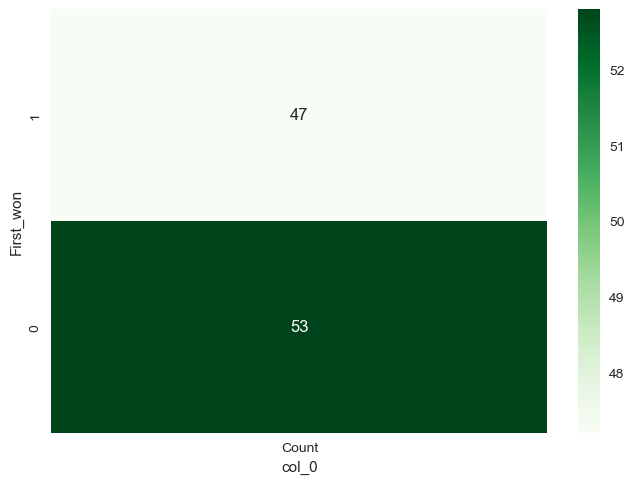

In [72]:
target_t = pd.DataFrame(pd.crosstab(all_data.First_won, columns = 'Count', normalize='columns'))
target_t = target_t * 100

ax = sns.heatmap(target_t, annot = True, cmap="Greens")
ax.invert_yaxis()

### Numerical data

In [152]:
num_cols = list(all_data.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
diff_vals = [col for col in all_data.columns if '_diff' in col]
pokemon_vals = [col for col in all_data.columns if '_pokemon' in col]
num_cols = (list(set(num_cols) - set(diff_vals + pokemon_vals)))
num_cols.remove('First_won')
print(num_cols)

['Attack_valdiff', 'First_Ratio', 'Generation_valdiff', 'Second_Defense', 'First_HP', 'First_Attack', 'Second_HP', 'Defense_valdiff', 'Second_Generation', 'Second_Sp_Atk', 'First_Sp_Def', 'Speed_valdiff', 'pokemon_valdiff', 'Second_Ratio', 'Sp_Def_valdiff', 'Sp_Atk_valdiff', 'Second_Speed_ratio', 'Second_Speed', 'Second_Attack', 'First_Defense', 'First_Speed_ratio', 'First_Generation', 'HP_valdiff', 'Second_Sp_Def', 'First_Speed', 'First_Sp_Atk']


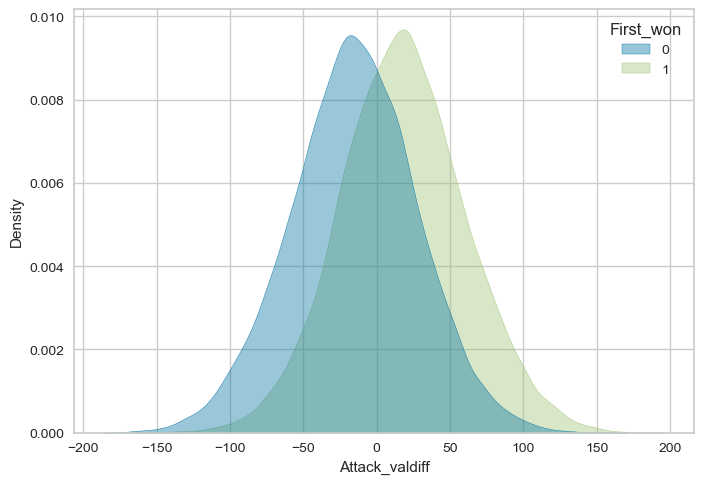

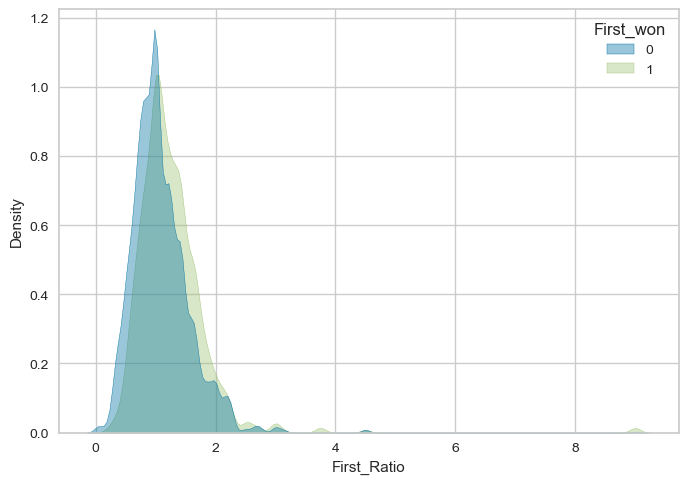

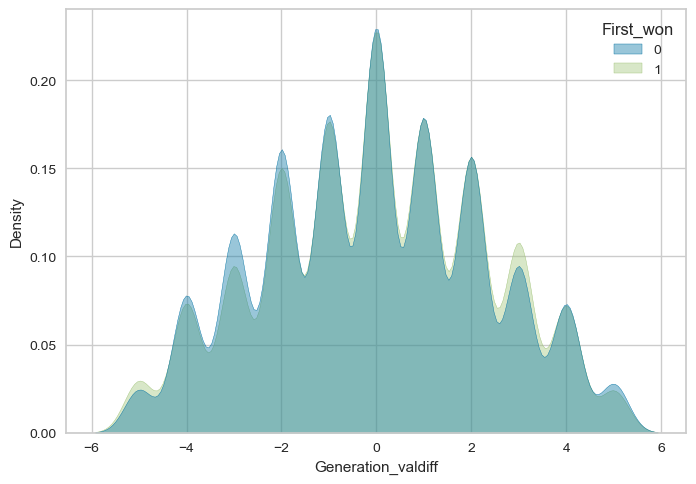

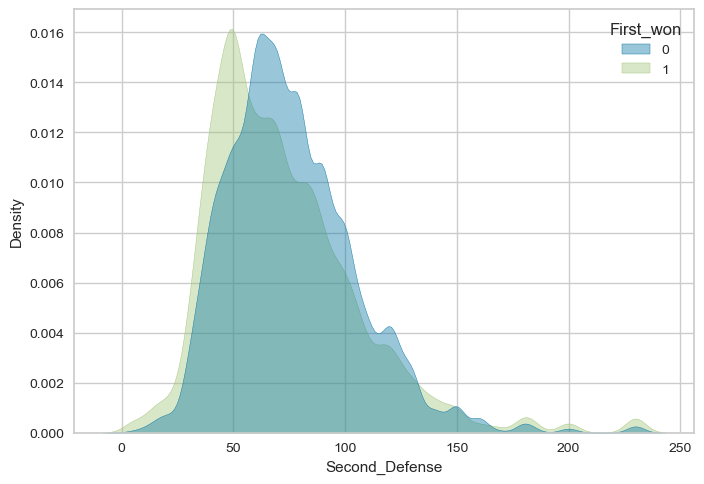

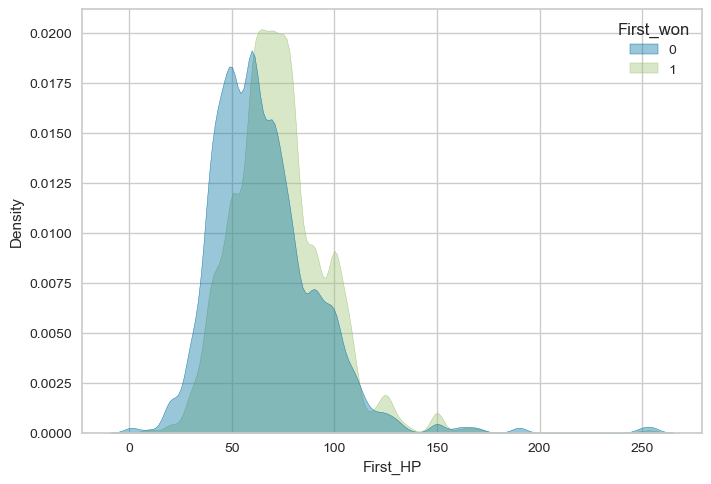

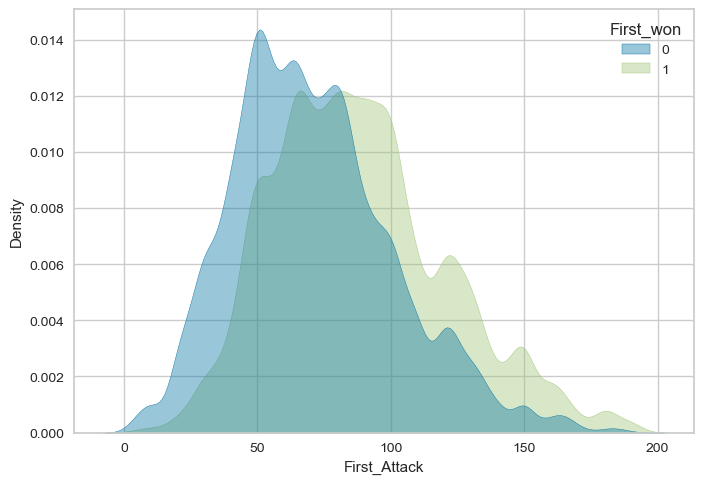

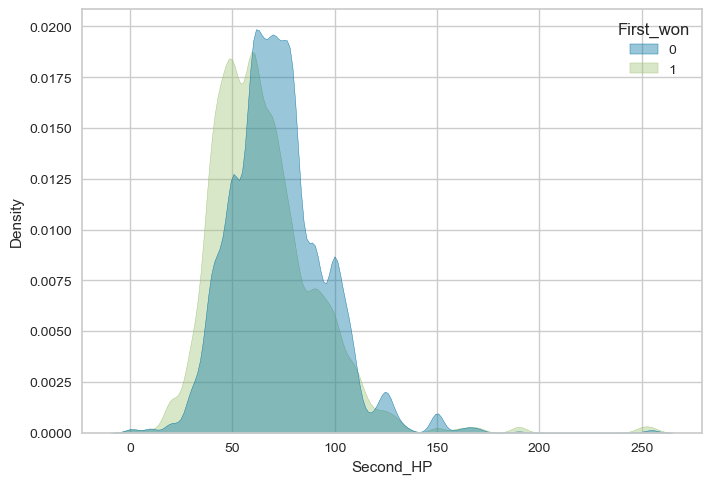

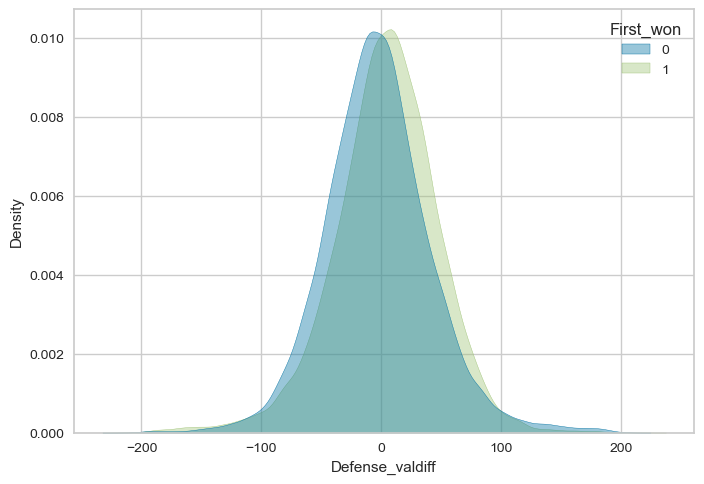

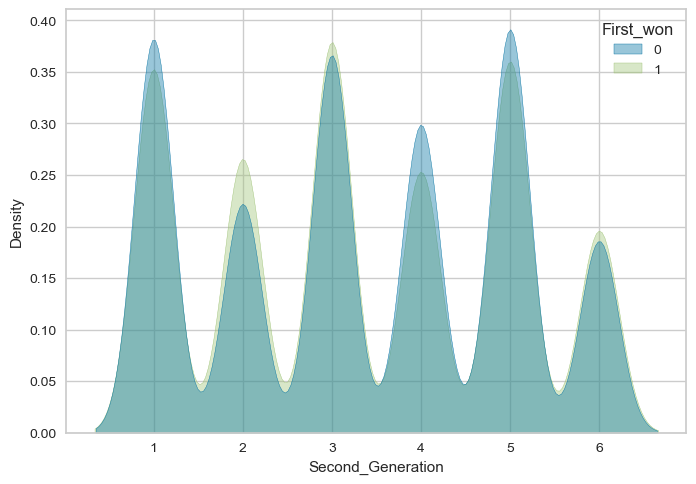

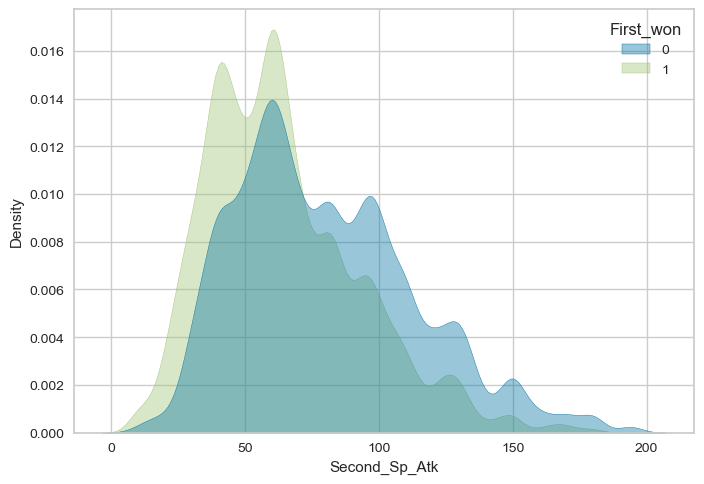

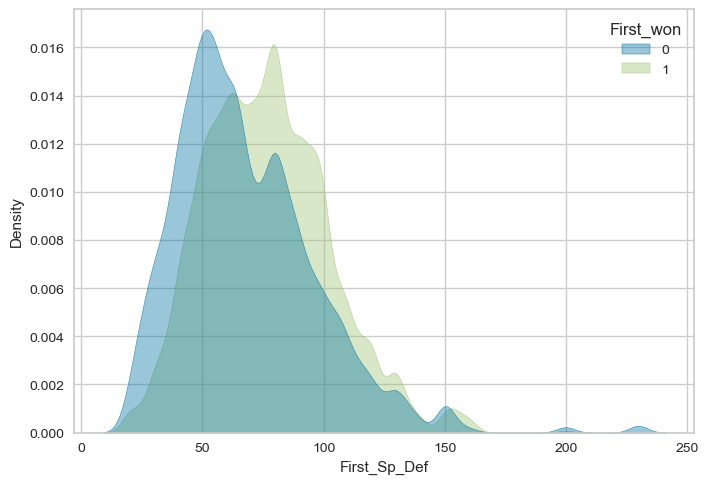

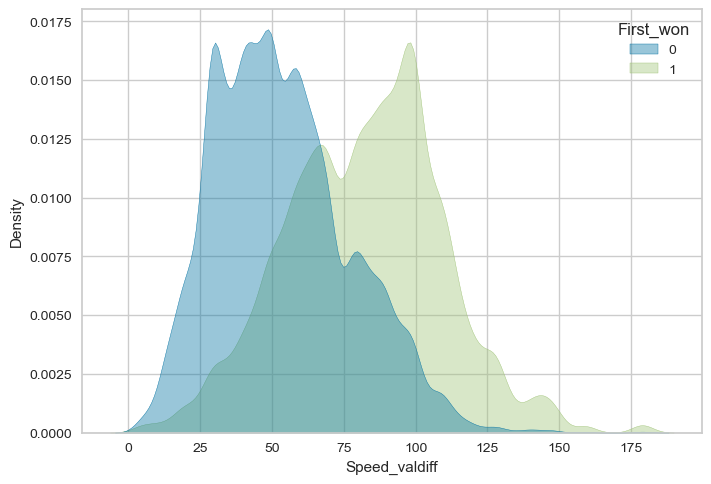

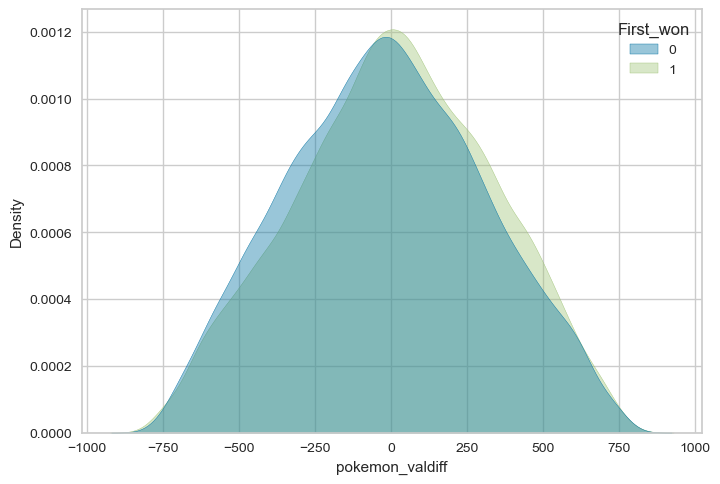

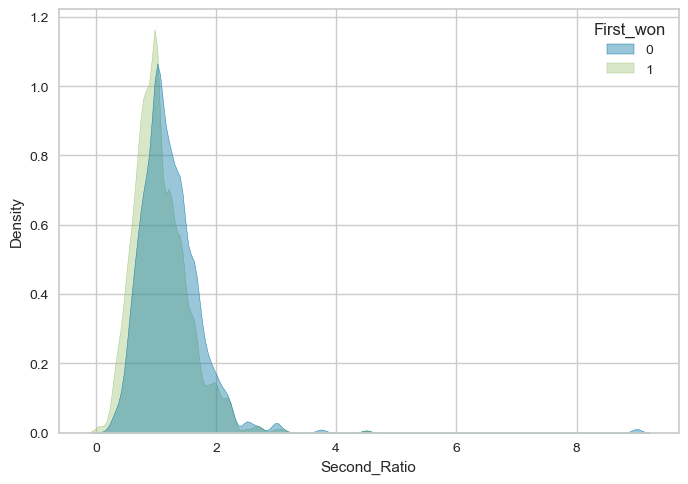

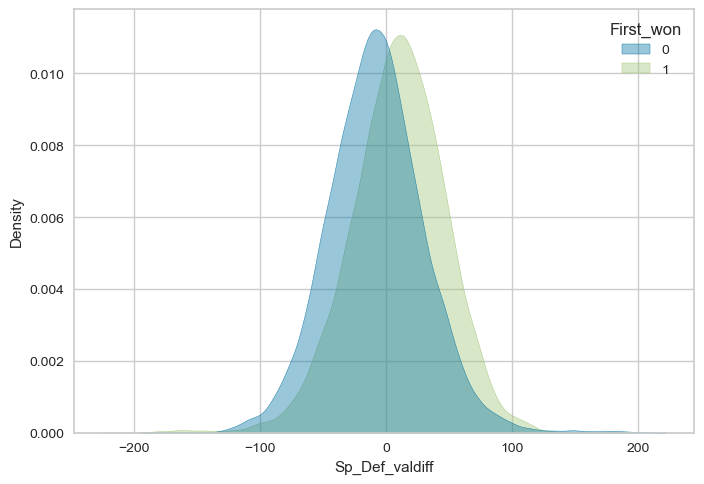

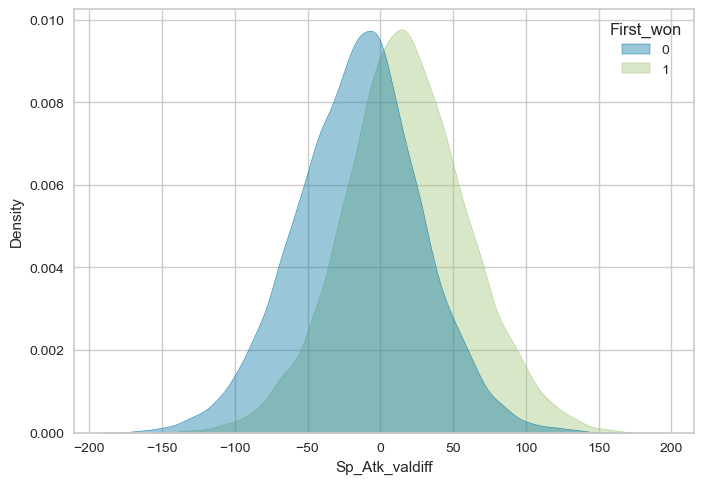

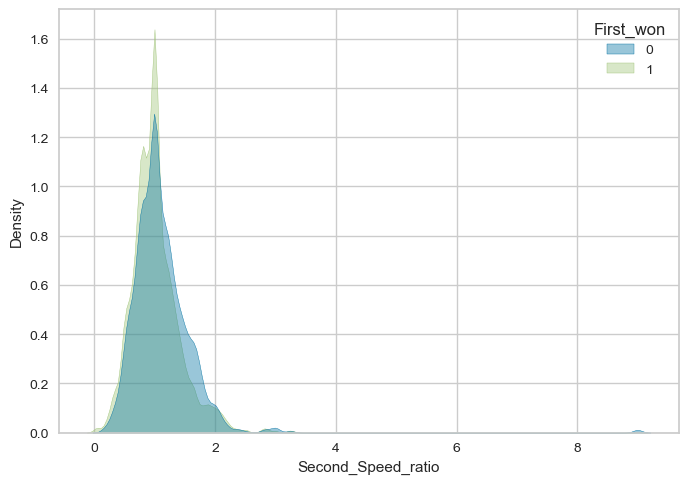

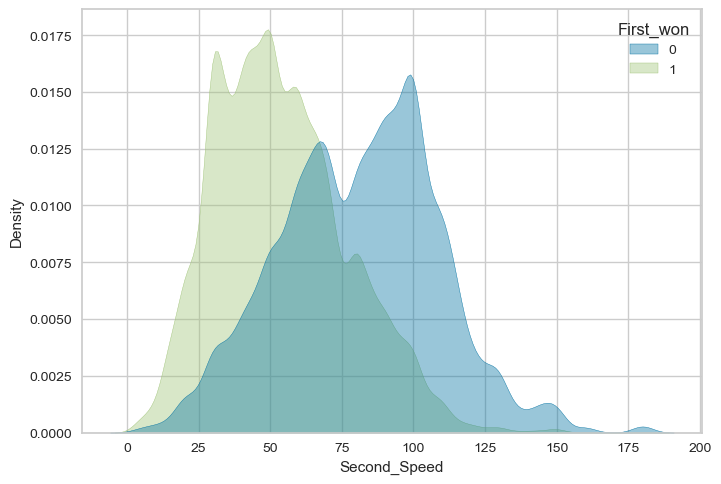

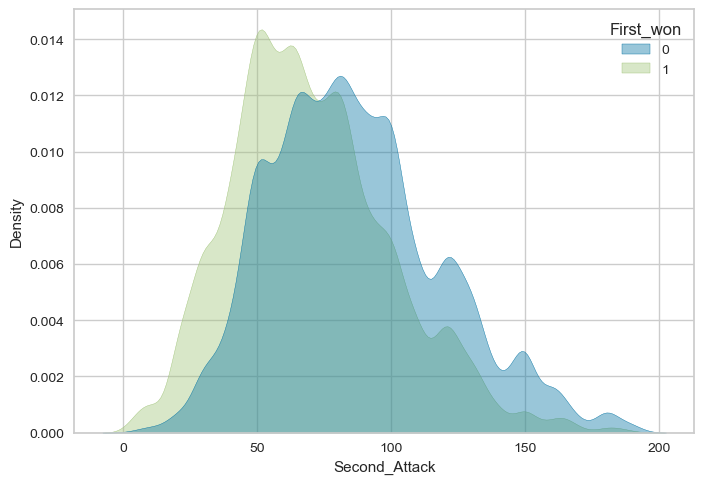

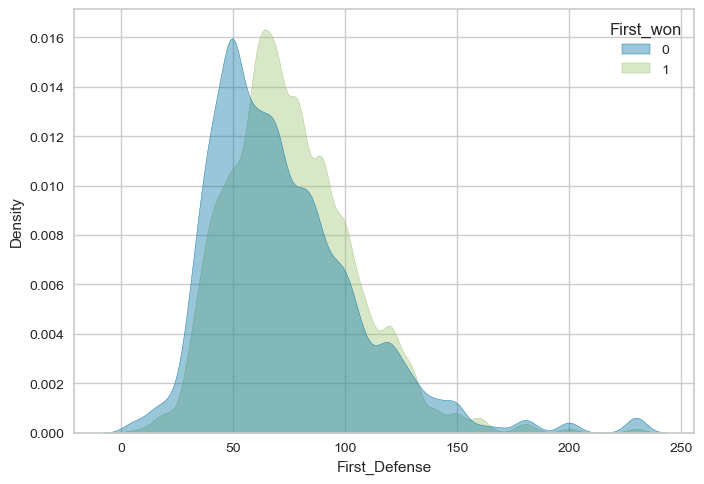

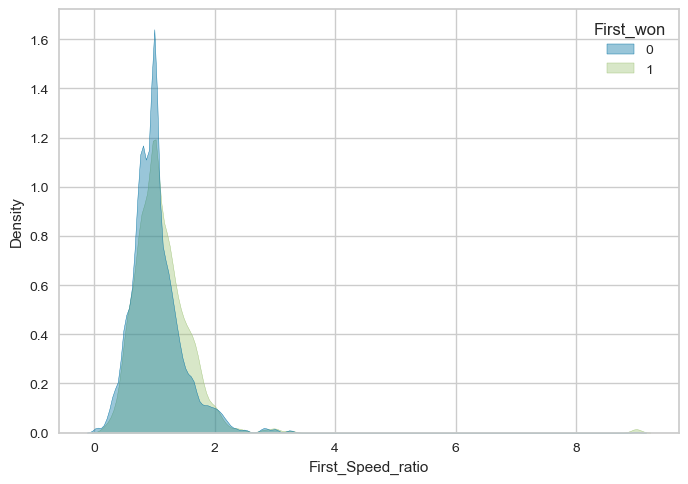

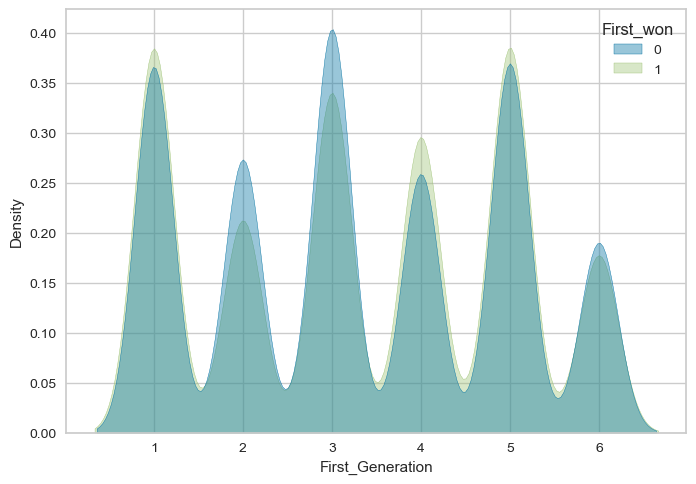

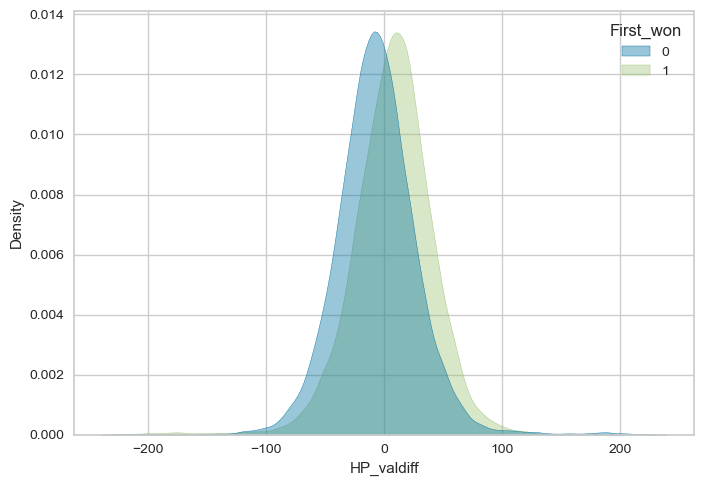

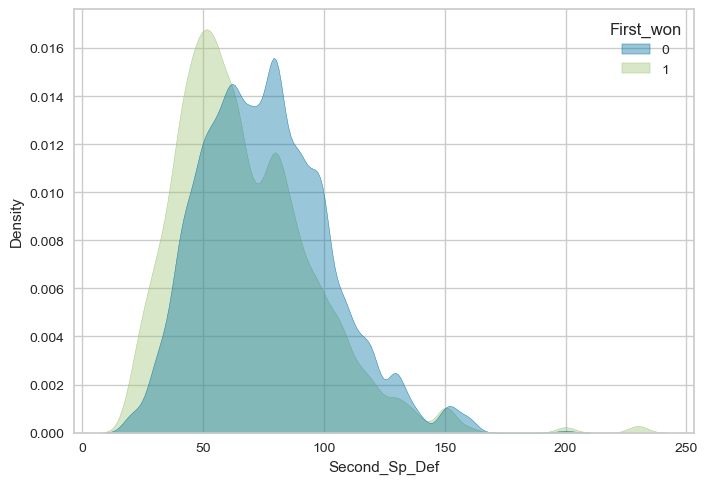

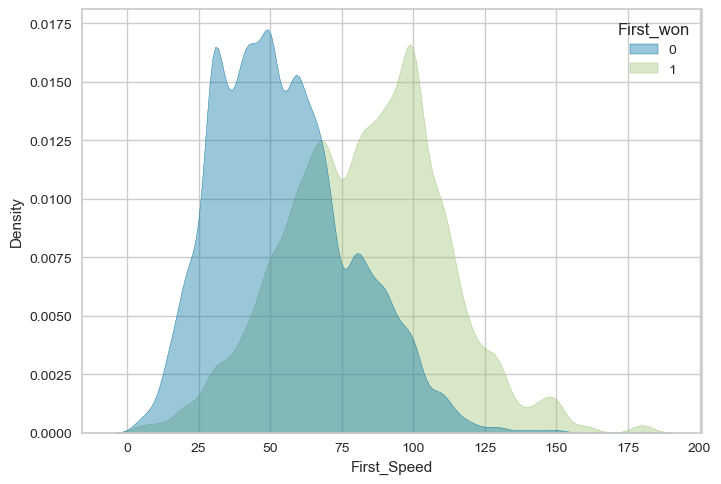

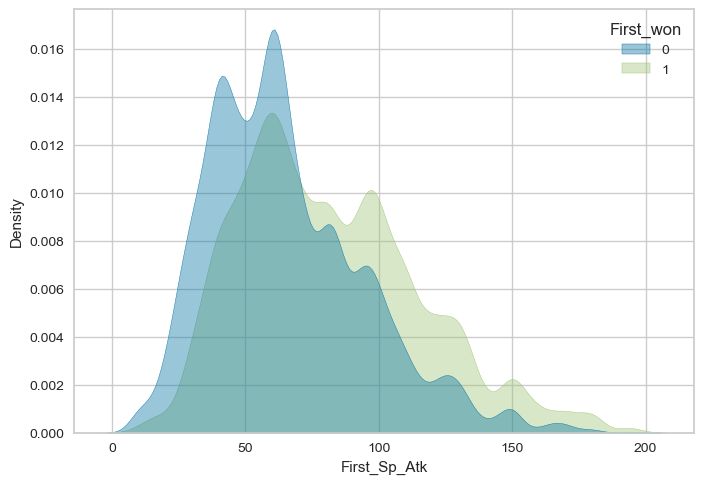

In [145]:
for name in num_cols:
    sns.kdeplot(data=all_data, x=name, hue="First_won", fill=True, common_norm=False, alpha=0.4)
    plt.show()

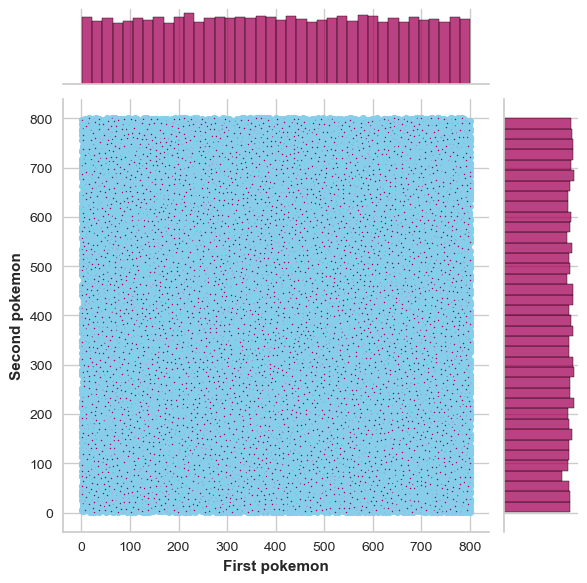

In [77]:
ax = sns.jointplot(x=all_data['First_pokemon'], y=all_data['Second_pokemon'], 
                   kind='scatter', s=10, color='m', edgecolor="skyblue", linewidth=2)
ax.ax_joint.set_xlabel('First pokemon', fontweight='bold')
ax.ax_joint.set_ylabel('Second pokemon', fontweight='bold')
plt.show()

['First_HP', 'Second_HP', 'First_Attack', 'Second_Attack', 'First_Defense', 'Second_Defense', 'First_Sp_Atk', 'Second_Sp_Atk', 'First_Sp_Def', 'Second_Sp_Def', 'First_Speed', 'Second_Speed']
(500, 13)


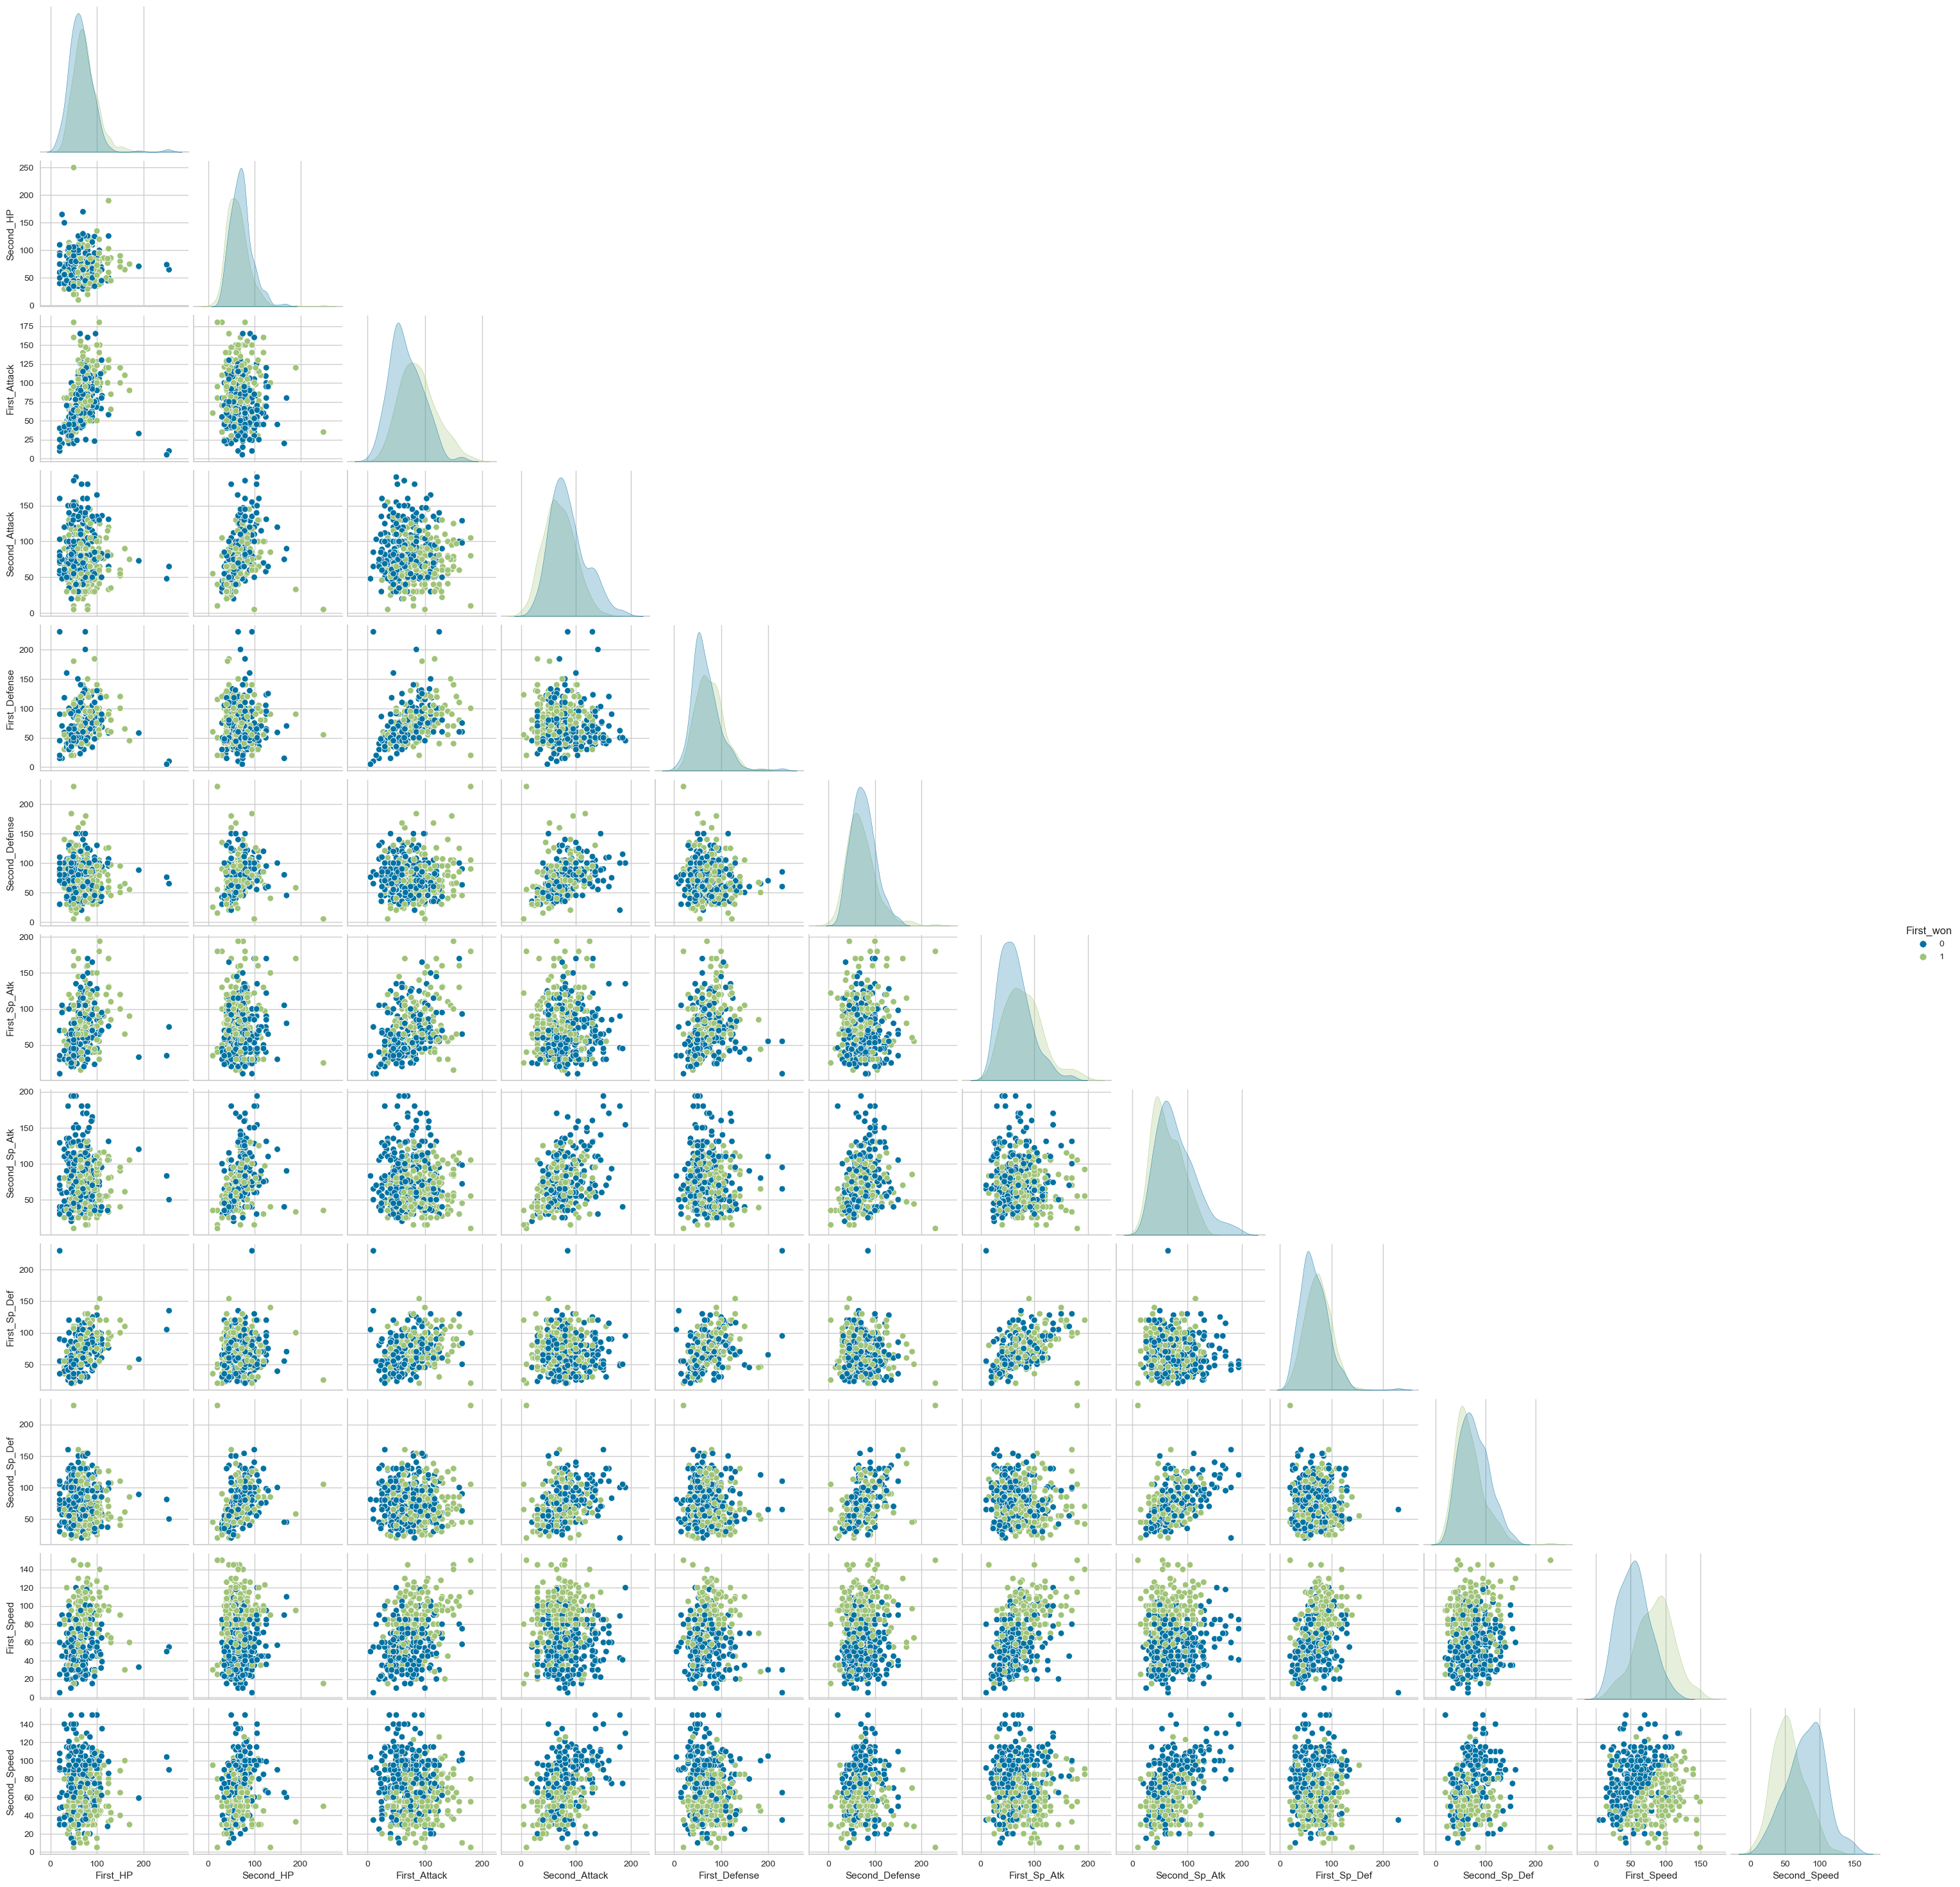

In [95]:
pplot = all_data.sample(frac =.01)
num_cols_po = ['First_HP', 'Second_HP', 'First_Attack', 'Second_Attack', 'First_Defense', 'Second_Defense', 
               'First_Sp_Atk', 'Second_Sp_Atk', 'First_Sp_Def', 'Second_Sp_Def', 'First_Speed', 'Second_Speed']
print(num_cols_po)

pplot = pplot[num_cols_po + ['First_won']]
print(pplot.shape)
# (5000, 45)
sns.pairplot(pplot, hue = 'First_won', corner=True)
plt.show();

### Categorical data

In [105]:
cat_cols = list(all_data.select_dtypes(include=['object']))
cat_cols.remove('First_Name')
cat_cols.remove('Second_Name')
print(cat_cols)

['First_Type_1', 'First_Type_2', 'Second_Type_1', 'Second_Type_2', 'HP_diff', 'Attack_diff', 'Defense_diff', 'Sp_Atk_diff', 'Sp_Def_diff', 'Speed_diff', 'Generation_diff']


In [133]:
#a = all_data[all_data.First_Name == 'Mega Aerodactyl']
#pd.crosstab(a.First_won, columns = 'Count')

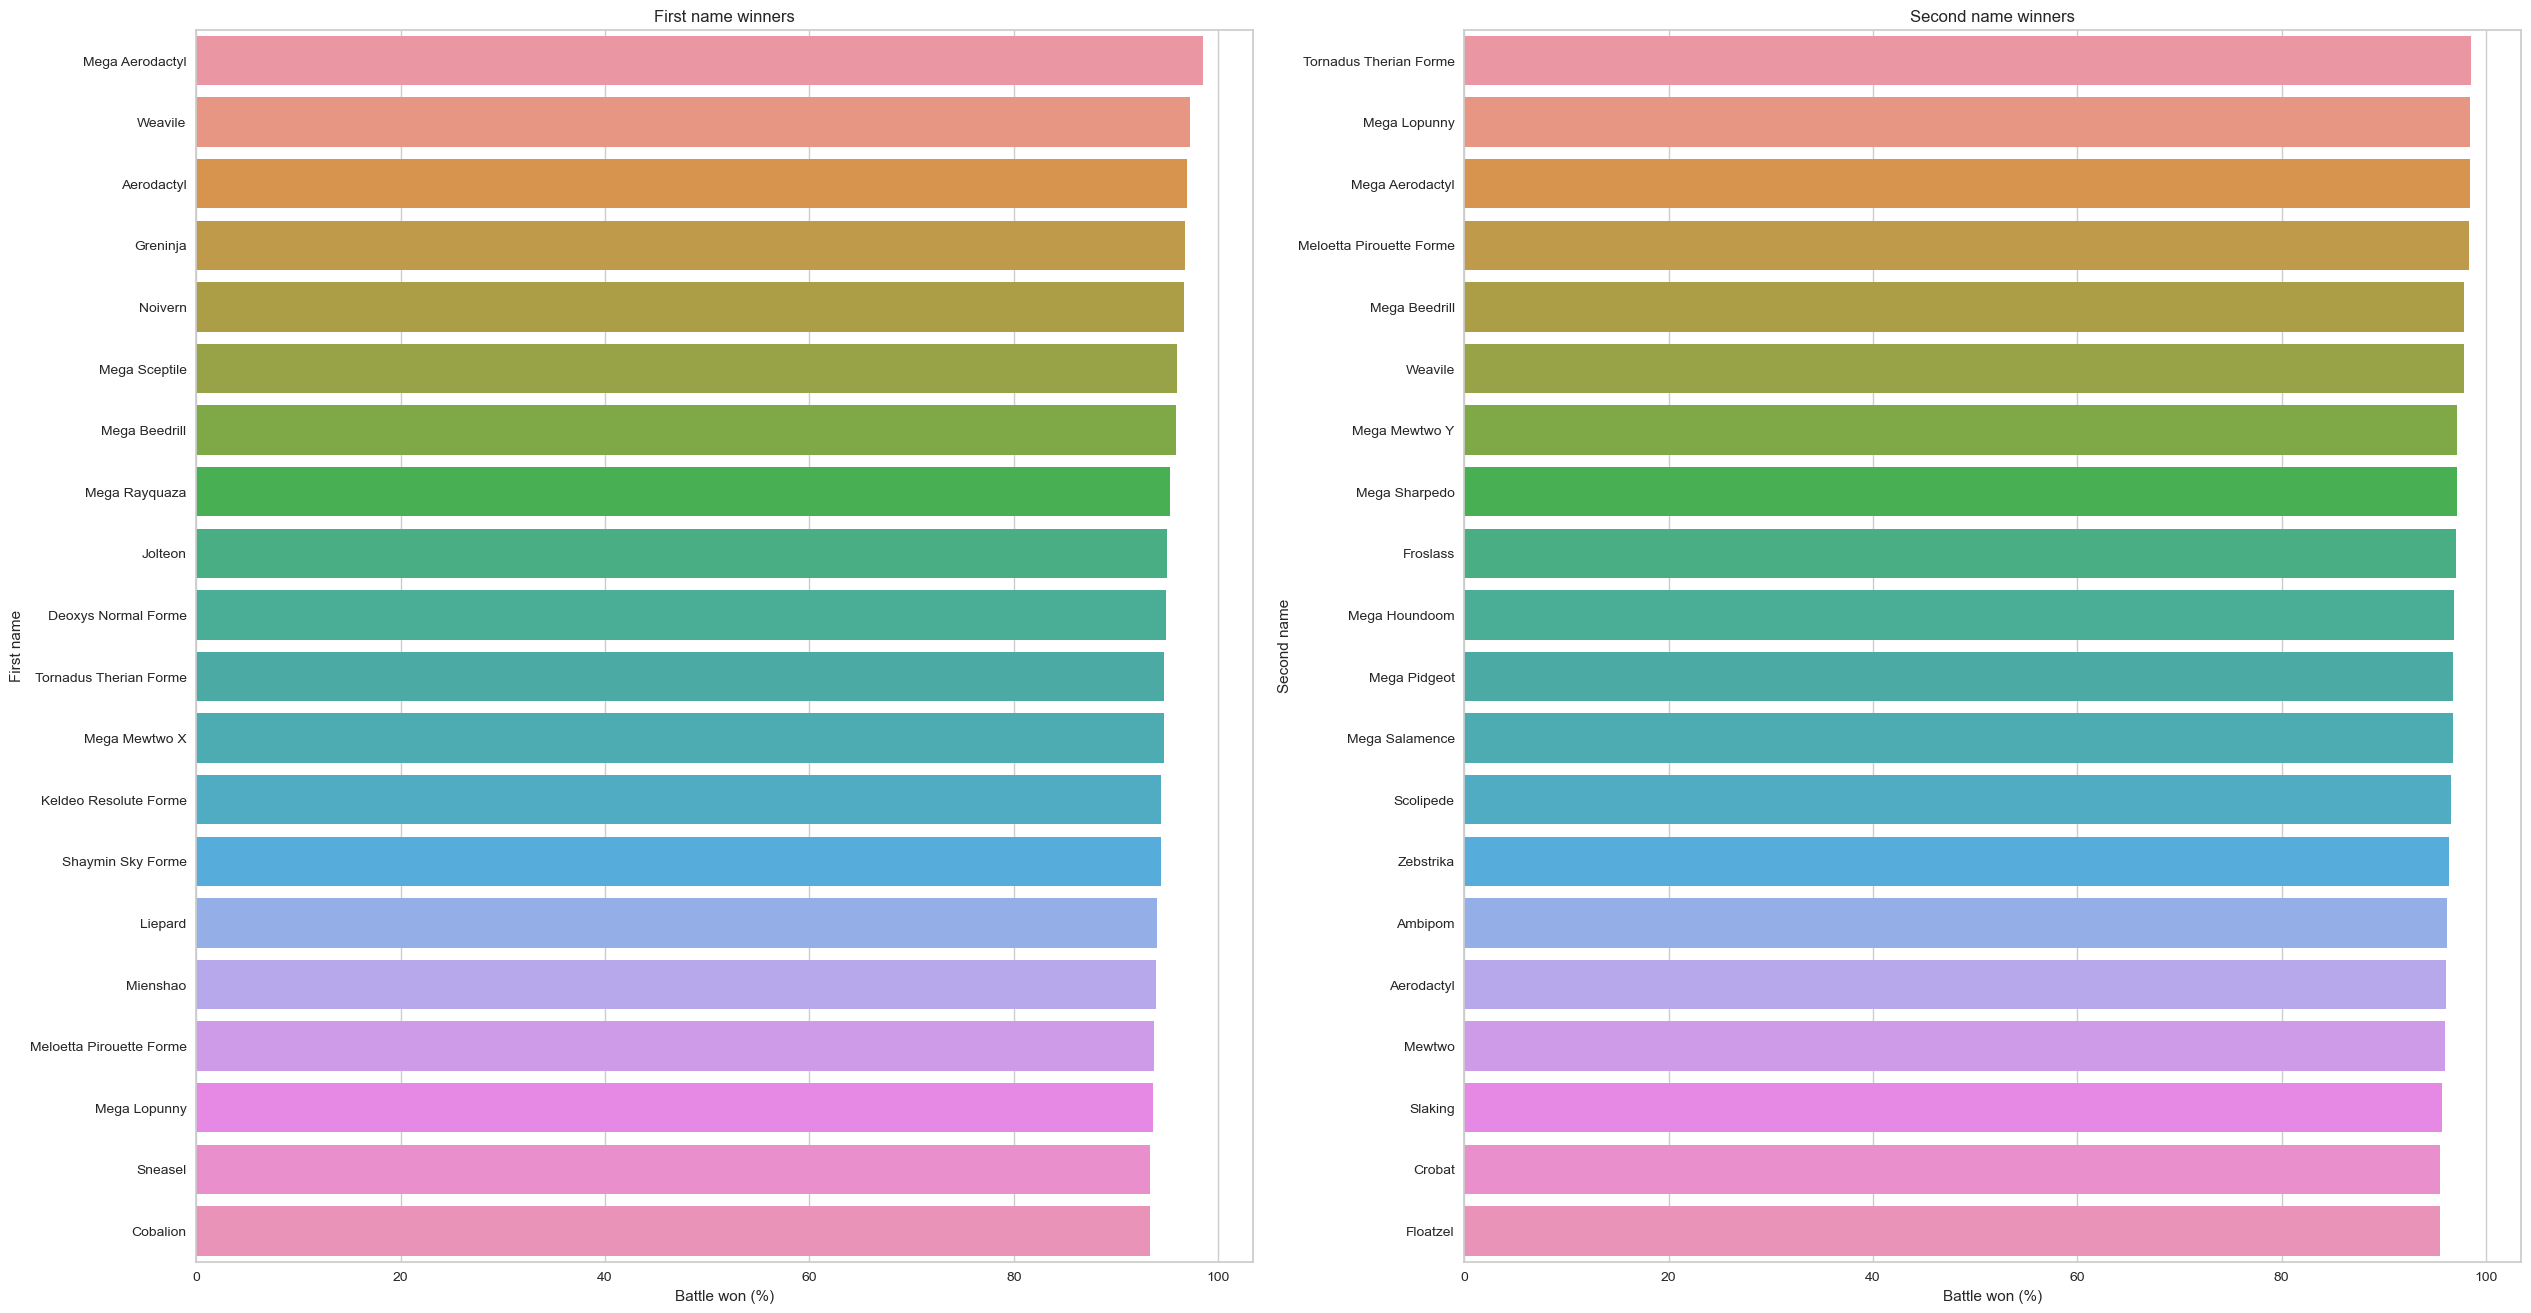

In [149]:
fig, ax=plt.subplots(1, 2, figsize=(30, 16))

name = 'First_Name'
c_loc = all_data.sort_values(by = name)
c_loc = c_loc.groupby([name])['First_won'].mean()
c_loc = c_loc.reset_index()
c_loc.First_won = c_loc.First_won * 100
c_loc = c_loc.sort_values(['First_won'], ascending = False)
c_loc = c_loc.iloc[:20,:]

name = 'Second_Name'
c_loca = all_data.sort_values(by = name)
c_loca = c_loca.groupby([name])['First_won'].mean()
c_loca = c_loca.reset_index()
c_loca.First_won = (1 - c_loca.First_won) * 100
c_loca = c_loca.sort_values(['First_won'], ascending = False)
c_loca = c_loca.iloc[:20,:]

sns.set_color_codes("muted")
g1 = sns.barplot(x = "First_won", y = "First_Name", data = c_loc, orient = "h", ax=ax[0])
g1.set(xlabel = 'Battle won (%)', ylabel = 'First name')
g1.set_title("First name winners")

g2 = sns.barplot(x = "First_won", y = "Second_Name", data = c_loca, orient = "h", ax=ax[1])
g2.set(xlabel = 'Battle won (%)', ylabel = 'Second name')
g2.set_title("Second name winners")

plt.show();

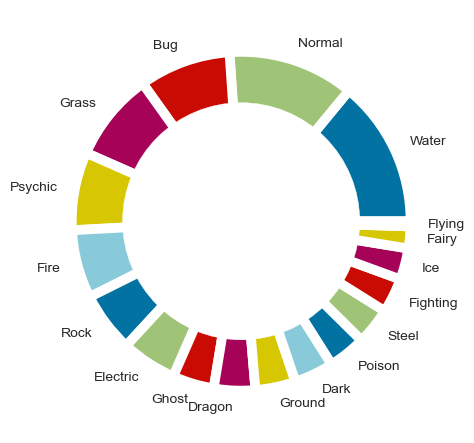

In [102]:
name = 'First_Type_1'
c_loc = all_data.sort_values(by = name)
c_loc = c_loc.groupby([name])['First_won'].count()
c_loc = c_loc.reset_index()
c_loc['perc'] = c_loc['First_won']/all_data.shape[0] * 100
c_loc = c_loc.sort_values(by = 'perc', ascending = False)
c_loc['cum_perc'] = c_loc['perc'].cumsum()
c_loc = c_loc.reset_index(drop=True)
c_loca = c_loc[c_loc.cum_perc < 90]

my_circle = plt.Circle( (0,0), 0.7, color='white')

plt.pie(c_loc.perc, labels=c_loc[name], wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

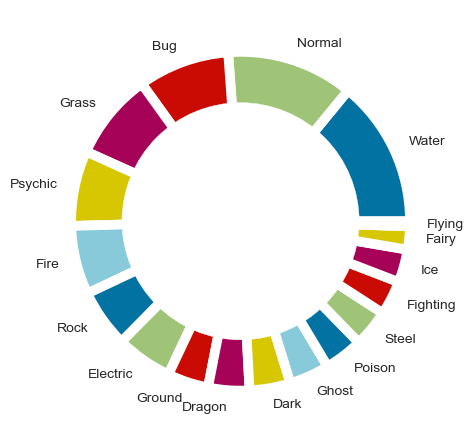

In [103]:
name = 'Second_Type_1'
c_loc = all_data.sort_values(by = name)
c_loc = c_loc.groupby([name])['First_won'].count()
c_loc = c_loc.reset_index()
c_loc['perc'] = c_loc['First_won']/all_data.shape[0] * 100
c_loc = c_loc.sort_values(by = 'perc', ascending = False)
c_loc['cum_perc'] = c_loc['perc'].cumsum()
c_loc = c_loc.reset_index(drop=True)
c_loca = c_loc[c_loc.cum_perc < 90]

my_circle = plt.Circle( (0,0), 0.7, color='white')

plt.pie(c_loc.perc, labels=c_loc[name], wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

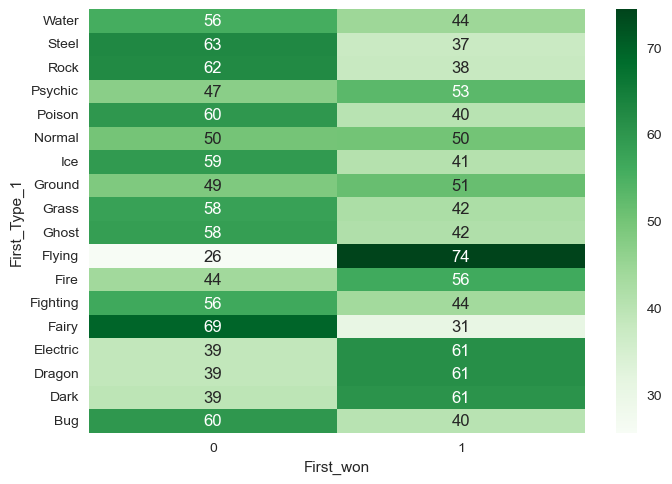

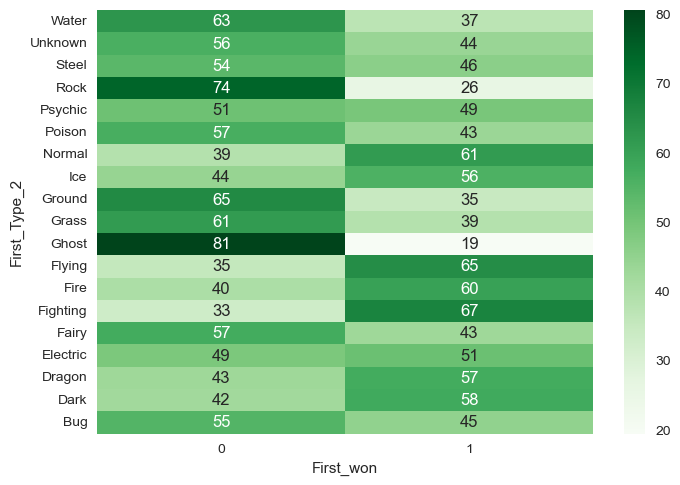

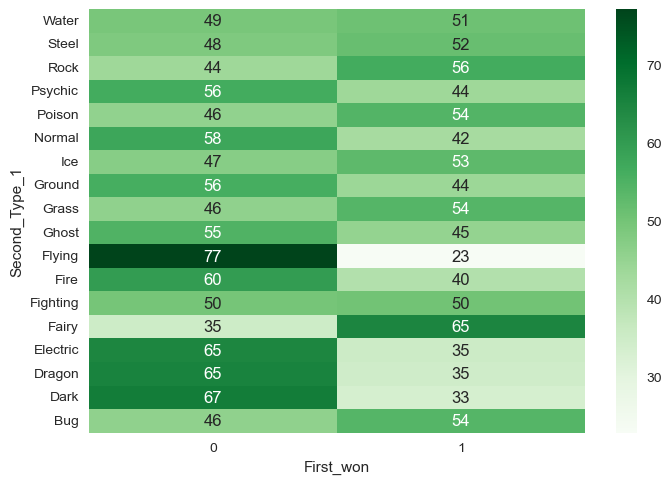

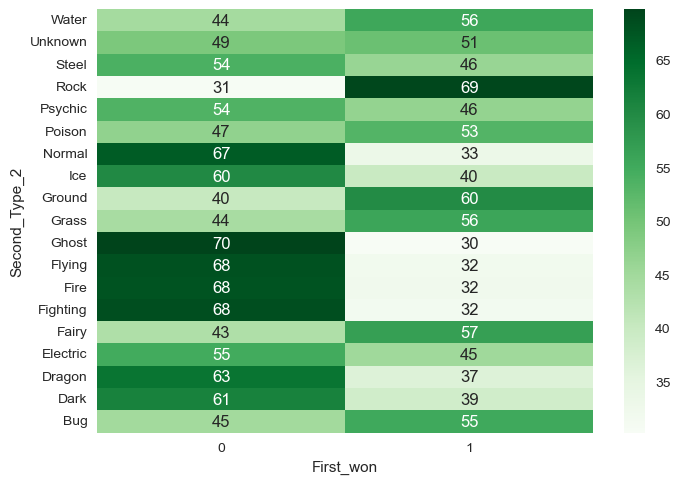

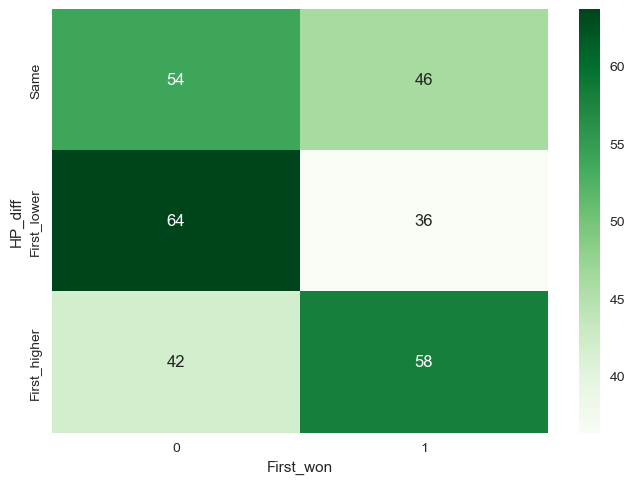

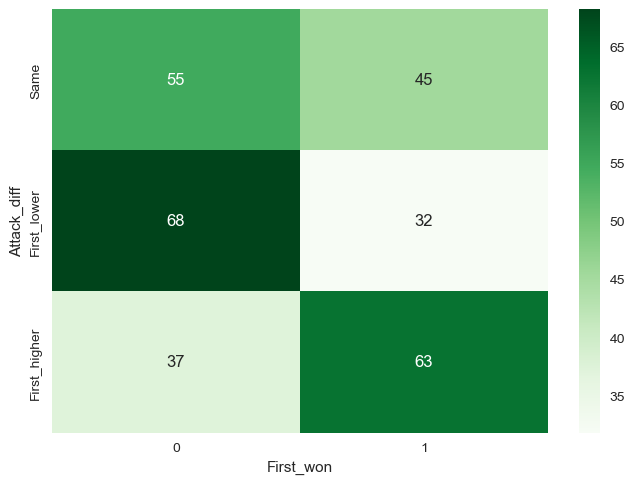

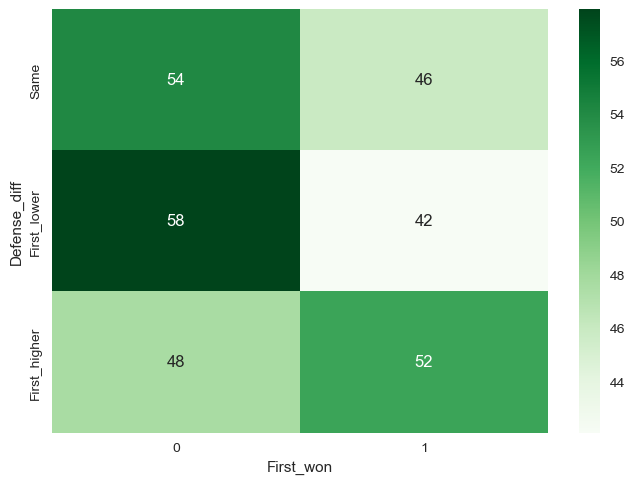

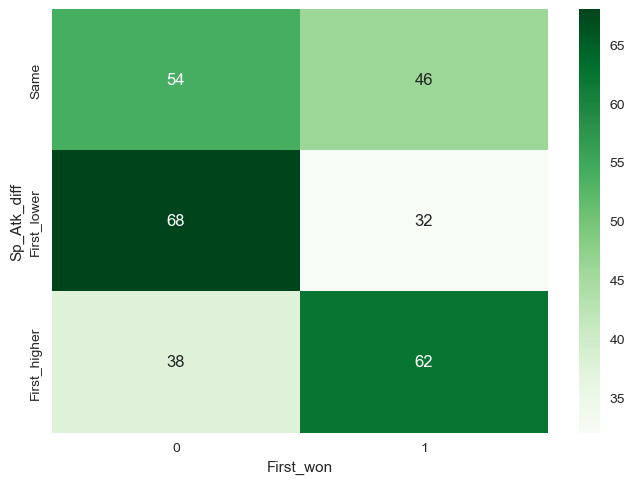

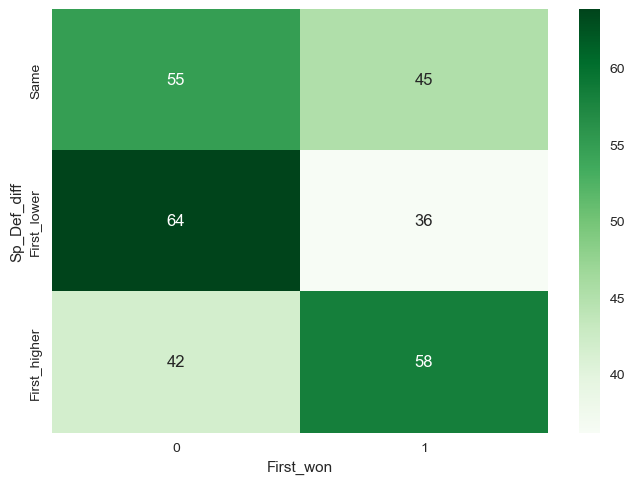

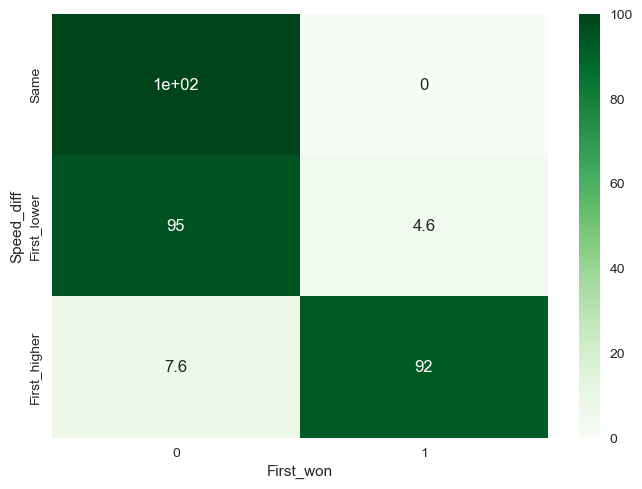

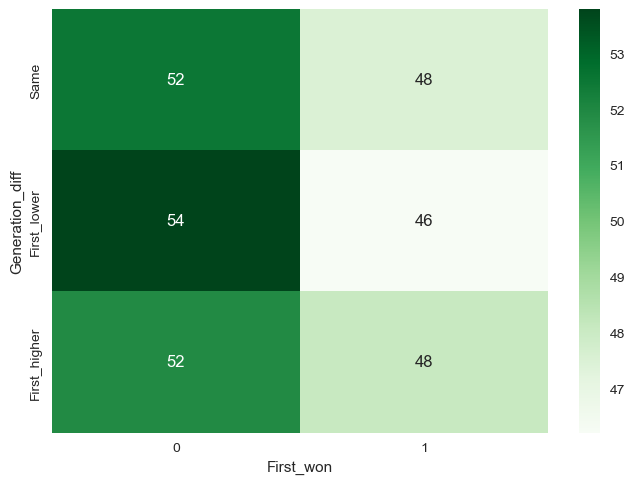

In [106]:
for name in cat_cols:
    cross_tab = pd.DataFrame(pd.crosstab(all_data[name], all_data.First_won, normalize='index'))
    cross_tab = cross_tab * 100

    ax = sns.heatmap(cross_tab, annot = True, cmap="Greens")
    ax.invert_yaxis()
    plt.show();

### Interaction terms

In [ ]:
# Speed_valdiff         0.479994
# Speed_diff            0.467272
# First_Name            0.160366
# Second_Name           0.150495
# First_Speed           0.138843
# Second_Speed          0.127713
# Attack_valdiff        0.074030
# Sp_Atk_valdiff        0.069680

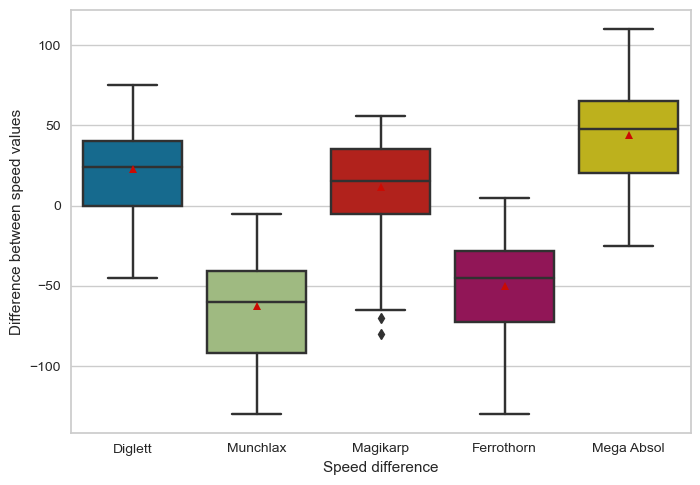

In [74]:
box_p = all_data[all_data.First_Name.isin(['Munchlax', 'Ferrothorn', 'Diglett', 'Mega Absol', 'Magikarp'])]

sns.boxplot(data=box_p, x = "First_Name", y = "Speed_valdiff", showmeans = True)
plt.xlabel("Speed difference")
plt.ylabel("Difference between speed values")
plt.show()

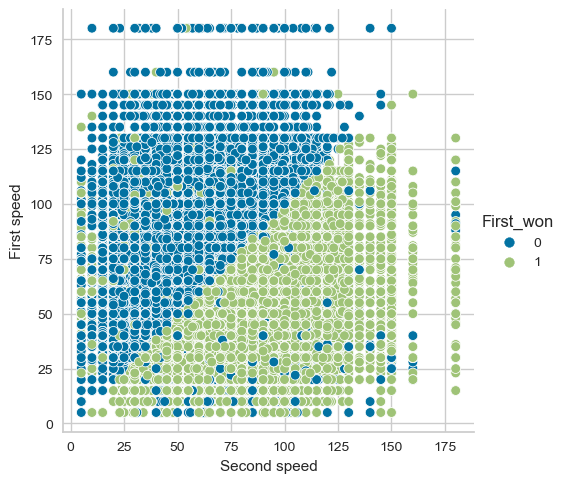

In [83]:
sns.relplot(x = 'First_Speed',
            y = 'Second_Speed',
            data = all_data,
            kind='scatter',
            hue='First_won')
plt.ylabel("First speed")
plt.xlabel("Second speed")
plt.show();

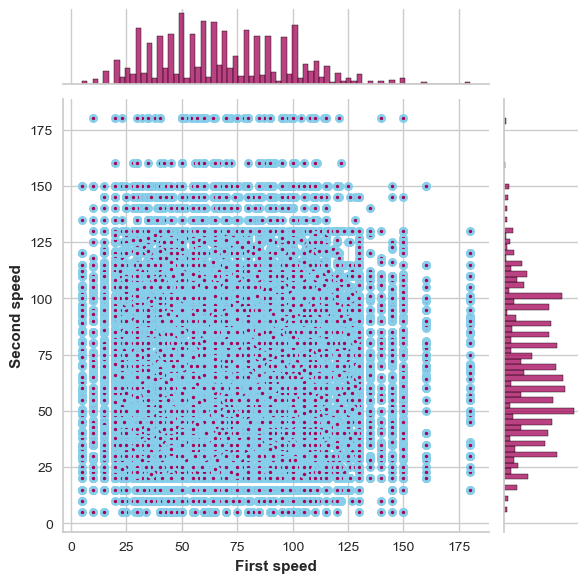

In [84]:
ax = sns.jointplot(x = all_data['First_Speed'], y = all_data['Second_Speed'], kind='scatter', 
                   s=20, color='m', edgecolor="skyblue", linewidth=2)
ax.ax_joint.set_xlabel('First speed', fontweight='bold')
ax.ax_joint.set_ylabel('Second speed', fontweight='bold')
plt.show()

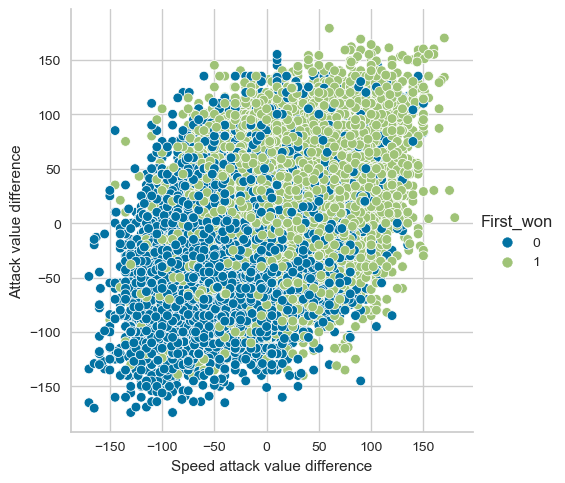

In [85]:
sns.relplot(x = 'Attack_valdiff',
            y = 'Sp_Atk_valdiff',
            data = all_data,
            kind='scatter',
            hue='First_won')
plt.ylabel("Attack value difference")
plt.xlabel("Speed attack value difference")
plt.show();

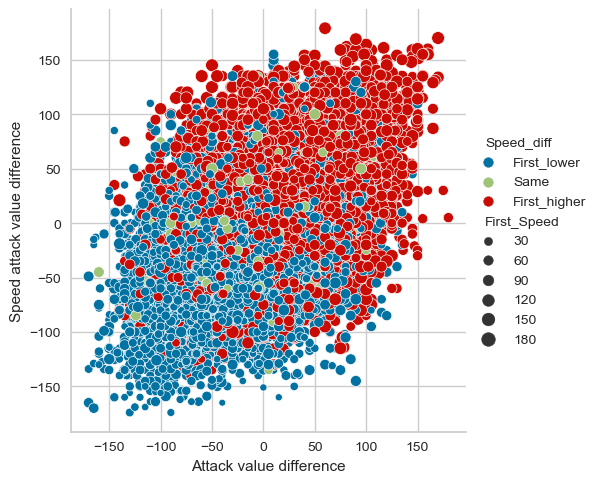

In [88]:
# Speed_valdiff         0.479994
# Speed_diff            0.467272
# First_Name            0.160366
# Second_Name           0.150495
# First_Speed           0.138843
# Second_Speed          0.127713
# Attack_valdiff        0.074030
# Sp_Atk_valdiff        0.069680

sns.relplot(x = 'Attack_valdiff',
            y = 'Sp_Atk_valdiff',
            data = all_data,
            kind='scatter',
            size = 'First_Speed',
            hue = 'Speed_diff')
plt.xlabel("Attack value difference")
plt.ylabel("Speed attack value difference")
plt.show();

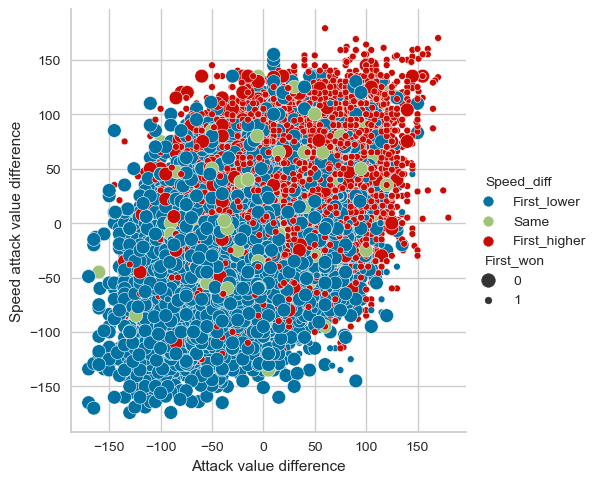

In [89]:
sns.relplot(x = 'Attack_valdiff',
            y = 'Sp_Atk_valdiff',
            data = all_data,
            kind='scatter',
            size = 'First_won',
            hue = 'Speed_diff')
plt.xlabel("Attack value difference")
plt.ylabel("Speed attack value difference")
plt.show();

### Test/Train split

In [164]:
a = list(all_data.columns)
a.sort()
print(a)

['Attack_diff', 'Attack_valdiff', 'Defense_diff', 'Defense_valdiff', 'First_Attack', 'First_Defense', 'First_Generation', 'First_HP', 'First_Legendary', 'First_Name', 'First_Ratio', 'First_Sp_Atk', 'First_Sp_Def', 'First_Speed', 'First_Speed_ratio', 'First_Type_1', 'First_Type_2', 'First_pokemon', 'First_won', 'Generation_diff', 'Generation_valdiff', 'HP_diff', 'HP_valdiff', 'Legendary_diff', 'Name_diffn', 'Ratio_diff', 'Second_Attack', 'Second_Defense', 'Second_Generation', 'Second_HP', 'Second_Legendary', 'Second_Name', 'Second_Ratio', 'Second_Sp_Atk', 'Second_Sp_Def', 'Second_Speed', 'Second_Speed_ratio', 'Second_Type_1', 'Second_Type_2', 'Second_pokemon', 'Sp_Atk_diff', 'Sp_Atk_valdiff', 'Sp_Def_diff', 'Sp_Def_valdiff', 'Speed_diff', 'Speed_ratio_diff', 'Speed_valdiff', 'Type_1_diffn', 'Type_2_diffn', 'pokemon_diff', 'pokemon_valdiff']


In [165]:
y = all_data.First_won
X = all_data.drop(['First_won','First_pokemon','Second_pokemon'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.4,
                                                    stratify = y,
                                                    random_state = 222)

print(X_train.shape, X_test.shape)
# (4219, 20) (2813, 20)

print('First won rate train (%): ', round(y_train[y_train == 1].shape[0]/y_train.shape[0]*100,2))
print('First won rate test (%): ', round(y_test[y_test == 1].shape[0]/y_test.shape[0]*100,2))

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train_orig = X_train.copy()

(30000, 48) (20000, 48)
First won rate train (%):  47.2
First won rate test (%):  47.2


### Examine the features

In [166]:
y = y_train.copy()
X = X_train.copy()

for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()
    
discrete_features = X.dtypes == int

In [167]:
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

First_Name            0.160366
Second_Name           0.150495
Speed_valdiff         0.143387
First_Speed           0.138843
Second_Speed          0.127713
First_Ratio           0.085425
First_Speed_ratio     0.075112
Attack_valdiff        0.074030
Second_Ratio          0.071090
Sp_Atk_valdiff        0.069680
Second_Speed_ratio    0.064169
First_Attack          0.050959
First_Sp_Atk          0.049811
Second_Attack         0.048659
Second_Sp_Atk         0.048055
Attack_diff           0.046698
Sp_Atk_diff           0.044395
Second_Sp_Def         0.039406
First_HP              0.039291
First_Sp_Def          0.039274
Sp_Def_valdiff        0.038897
Second_HP             0.037521
HP_valdiff            0.034987
First_Defense         0.033059
pokemon_valdiff       0.031101
Second_Defense        0.029378
Sp_Def_diff           0.022783
HP_diff               0.022449
First_Type_2          0.019238
Second_Type_2         0.017964
Defense_valdiff       0.016486
First_Type_1          0.012523
Second_L

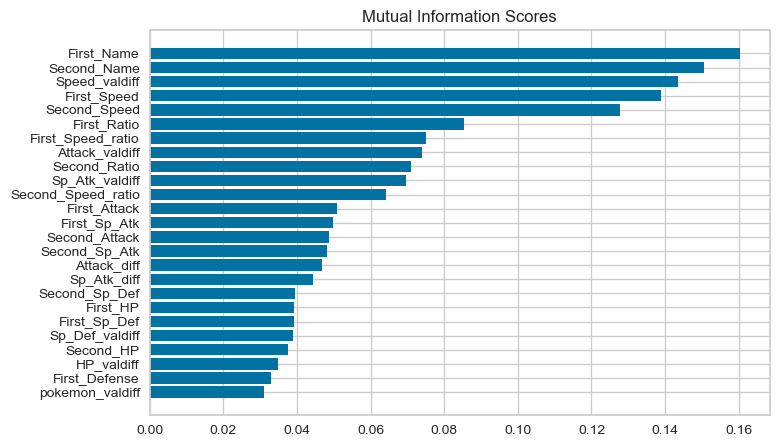

In [168]:
mi_scores = mi_scores[:25]
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)
plt.show();

### Features from tree classification

In [27]:
cat_cols = list(X_train.select_dtypes(include=['object']))
print(cat_cols)

ohe = OneHotEncoder()
ohe.fit(X_train[cat_cols])
colnames = ohe.get_feature_names_out(cat_cols)

cat_data_check = ohe_dset(X_train, cat_cols) 
print(cat_data_check.shape)

['First_Name', 'First_Type_1', 'First_Type_2', 'Second_Name', 'Second_Type_1', 'Second_Type_2', 'HP_diff', 'Attack_diff', 'Defense_diff', 'Sp_Atk_diff', 'Sp_Def_diff', 'Speed_diff', 'Generation_diff', 'pokemon_diff']
(30000, 1665)
(30000, 1665)


In [28]:
num_cols = list(X_train.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
print(num_cols)

['First_pokemon', 'Second_pokemon', 'First_HP', 'First_Attack', 'First_Defense', 'First_Sp_Atk', 'First_Sp_Def', 'First_Speed', 'First_Generation', 'Second_HP', 'Second_Attack', 'Second_Defense', 'Second_Sp_Atk', 'Second_Sp_Def', 'Second_Speed', 'Second_Generation', 'Name_diffn', 'Type_1_diffn', 'Type_2_diffn', 'HP_valdiff', 'Attack_valdiff', 'Defense_valdiff', 'Sp_Atk_valdiff', 'Sp_Def_valdiff', 'Speed_valdiff', 'Generation_valdiff', 'Legendary_diff', 'pokemon_valdiff']


In [42]:
X_tree = pd.concat([X_train[num_cols], cat_data_check], axis = 1)
y_tree = y_train

print(X_tree.shape, y_tree.shape)

(30000, 1693) (30000,)


In [43]:
clf = DecisionTreeClassifier(max_depth=5, random_state=1234)

In [60]:
rule_lst = []
flattened_lst = []
flattened_lsts = []

minutes = 2
t_end = time.time() + 60 * minutes

#while time.time() < t_end:
for split_size in tqdm([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]):
    X_trees, X_tree_test, y_trees, y_tree_test = train_test_split(X_tree,
                                                                  y_tree,
                                                                  test_size = split_size,
                                                                  stratify = y_tree,
                                                                  random_state = 222)
    print(X_trees.shape, y_trees.shape)
    
    model = clf.fit(X_trees, y_trees)
    text_representation = tree.export_text(clf, feature_names=list(X_trees.columns))
    rules, proba = get_rules(clf, list(X_trees.columns), [0,1], 80, 1000)
    rule_lst.append(list(set(rules)))
    flattened_lst = [val for sublist in rule_lst for val in sublist]
    flattened_lst = list(set(flattened_lst))

for i in range(len(flattened_lst)):
    flattened_lsts.append(flattened_lst[i].split(' then class')[0])
flattened_lsts = list(set(flattened_lsts))

  0%|          | 0/8 [00:00<?, ?it/s]

(27000, 1693) (27000,)


 12%|█▎        | 1/8 [00:01<00:13,  1.97s/it]

(24000, 1693) (24000,)


 25%|██▌       | 2/8 [00:03<00:11,  1.91s/it]

(21000, 1693) (21000,)


 38%|███▊      | 3/8 [00:05<00:08,  1.78s/it]

(18000, 1693) (18000,)


 50%|█████     | 4/8 [00:06<00:06,  1.66s/it]

(15000, 1693) (15000,)


 62%|██████▎   | 5/8 [00:08<00:04,  1.51s/it]

(12000, 1693) (12000,)


 75%|███████▌  | 6/8 [00:09<00:02,  1.37s/it]

(9000, 1693) (9000,)


 88%|████████▊ | 7/8 [00:10<00:01,  1.22s/it]

(6000, 1693) (6000,)


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


In [61]:
flattened_lsts

['if (Speed_valdiff <= 0.5) and (Second_Attack > 35.5) and (First_Name_Munchlax <= 0.5) and (Attack_valdiff <= 28.5) and (Second_Name_Diglett <= 0.5)',
 'if (Speed_valdiff > 0.5) and (Second_Type_2_Ghost <= 0.5) and (Attack_valdiff <= -27.5) and (Second_Speed > 41.5) and (First_HP > 27.5)',
 'if (Speed_valdiff <= 0.5) and (Attack_valdiff <= 32.5) and (First_Name_Munchlax <= 0.5) and (Second_Attack > 17.5) and (First_Name_Ferrothorn <= 0.5)',
 'if (Speed_valdiff > 0.5) and (Second_Type_2_Ghost <= 0.5) and (First_Attack > 23.5) and (Attack_valdiff > -17.5) and (Second_Type_1_Ghost <= 0.5)',
 'if (Speed_valdiff > 0.5) and (Second_Type_2_Ghost <= 0.5) and (Attack_valdiff <= -27.5) and (Second_Speed > 34.5) and (First_HP > 26.5)',
 'if (Speed_valdiff > 0.5) and (Second_Type_2_Ghost <= 0.5) and (Attack_valdiff > -18.5) and (Second_Type_1_Ghost <= 0.5) and (First_Type_2_Ghost <= 0.5)',
 'if (Speed_valdiff > 0.5) and (Second_Type_2_Ghost <= 0.5) and (First_Attack > 23.0) and (First_Type_2_Ghos

### New features

In [171]:
for i, dset in enumerate([X_train, X_test]):

    dseta = dset.copy()
    dseta['feature_1'] = 0
    dseta.loc[(dseta.Speed_valdiff > 0.5) & 
              (dseta.Second_Type_2 != 'Ghost') & 
              (dseta.Attack_valdiff > -27.5) & 
              (dseta.First_Type_2 != 'Ghost') & 
              (dseta.Second_Type_1 != 'Ghost'), 'feature_1'] = 1
    dseta['feature_2'] = 0
    dseta.loc[(dseta.Speed_valdiff > 0.5) &
              (dseta.Second_Type_2 != 'Ghost') & 
              (dseta.Attack_valdiff <= -27.5) & 
              (dseta.Second_Speed > 41.5) &
              (dseta.First_HP > 27.5), 'feature_2'] = 1    
    dseta['feature_3'] = 0
    dseta.loc[(dseta.Speed_valdiff <= 0.5) & 
              (dseta.Attack_valdiff <= 32.5) & 
              (dseta.First_Name != 'Munchlax') & 
              (dseta.Second_Attack > 17.5) & 
              (dseta.First_Name != 'Ferrothorn'), 'feature_3'] = 1        
    dseta['feature_4'] = 0
    dseta.loc[(dseta.Speed_valdiff <= 0.5) &
              (dseta.Second_Attack > 35.5) & 
              (dseta.First_Name != 'Munchlax') & 
              (dseta.Attack_valdiff <= 28.5) & 
              (dseta.Second_Name != 'Diglett'), 'feature_4'] = 1            
    dseta['feature_5'] = 0
    dseta.loc[(dseta.Speed_valdiff <= 0.5) &
              (dseta.Second_Attack > 35.5) & 
              (dseta.First_Name != 'Munchlax') & 
              (dseta.Attack_valdiff <= 28.5) & 
              (dseta.Second_Name != 'Diglett'), 'feature_5'] = 1      
    dseta['feature_6'] = 0
    dseta.loc[(dseta.Speed_valdiff <= 0.5) & 
              (dseta.Attack_valdiff > 32.5) & 
              (dseta.First_Speed > 34.0) & 
              (dseta.Speed_valdiff > -37.5) & 
              (dseta.Second_Sp_Atk > 22.5), 'feature_6'] = 1          

    if i == 0:
        X_train = dseta
    elif i == 1:
        X_test = dseta    

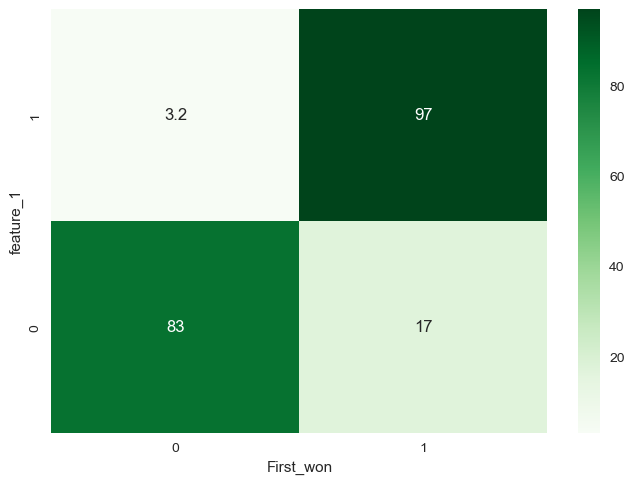

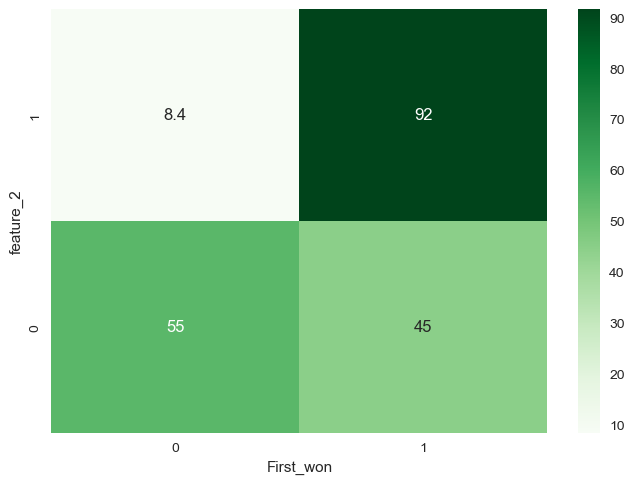

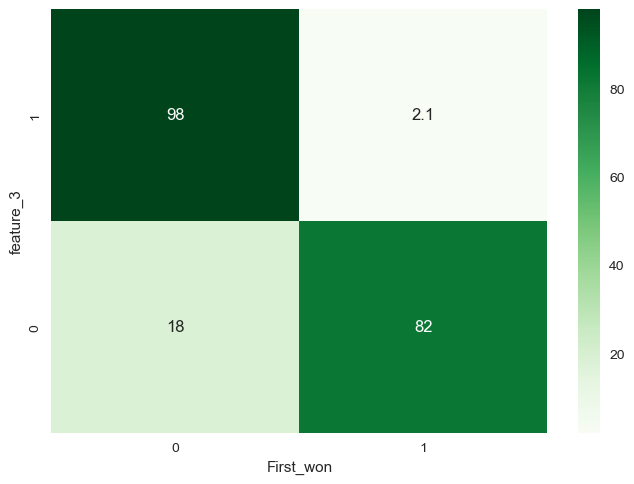

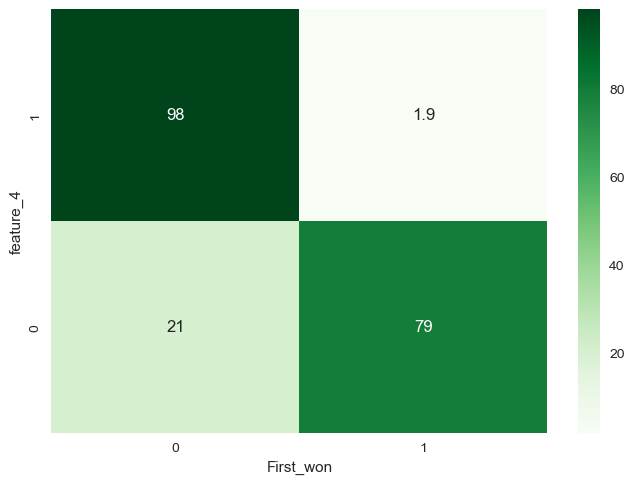

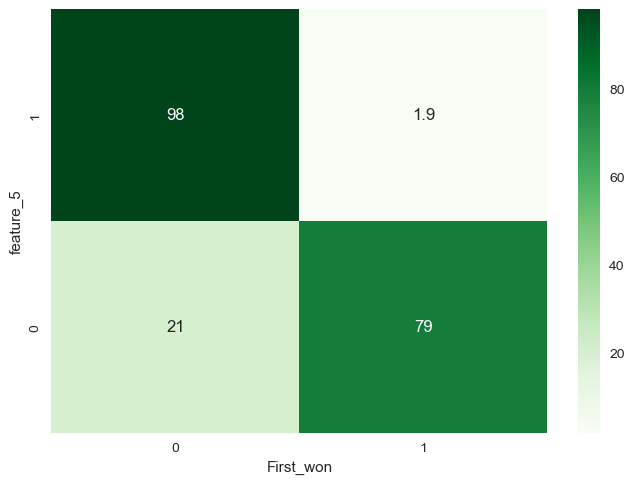

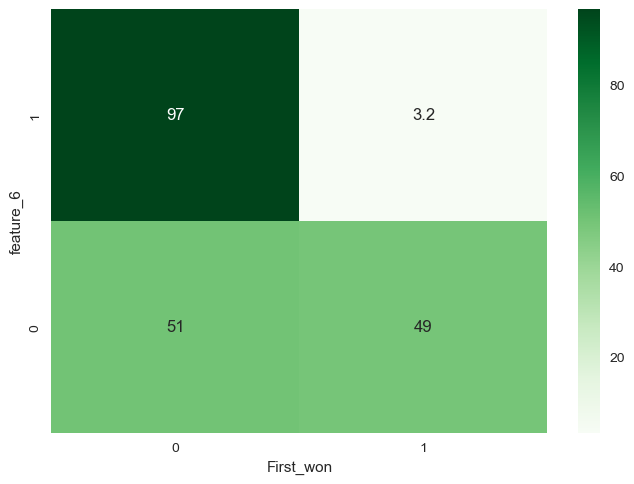

In [66]:
for name in [col for col in X_train.columns if 'feature_' in col]:
    cross_tab = pd.DataFrame(pd.crosstab(X_train[name], y_train, normalize='index'))
    cross_tab = cross_tab * 100

    ax = sns.heatmap(cross_tab, annot = True, cmap="Greens")
    ax.invert_yaxis()
    plt.show();

### Binning data

### Preprocess the model data

In [172]:
a = list(X_train.columns)
a.sort()
print(a)

X_train = X_train.drop(['pokemon_diff','pokemon_valdiff'], axis = 1)
X_test = X_test.drop(['pokemon_diff','pokemon_valdiff'], axis = 1)

['Attack_diff', 'Attack_valdiff', 'Defense_diff', 'Defense_valdiff', 'First_Attack', 'First_Defense', 'First_Generation', 'First_HP', 'First_Legendary', 'First_Name', 'First_Ratio', 'First_Sp_Atk', 'First_Sp_Def', 'First_Speed', 'First_Speed_ratio', 'First_Type_1', 'First_Type_2', 'Generation_diff', 'Generation_valdiff', 'HP_diff', 'HP_valdiff', 'Legendary_diff', 'Name_diffn', 'Ratio_diff', 'Second_Attack', 'Second_Defense', 'Second_Generation', 'Second_HP', 'Second_Legendary', 'Second_Name', 'Second_Ratio', 'Second_Sp_Atk', 'Second_Sp_Def', 'Second_Speed', 'Second_Speed_ratio', 'Second_Type_1', 'Second_Type_2', 'Sp_Atk_diff', 'Sp_Atk_valdiff', 'Sp_Def_diff', 'Sp_Def_valdiff', 'Speed_diff', 'Speed_ratio_diff', 'Speed_valdiff', 'Type_1_diffn', 'Type_2_diffn', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'pokemon_diff', 'pokemon_valdiff']


In [173]:
#########################################
### Check for single non varying data ###
#########################################

lst = []
for name in list(X_train.columns):
    if (X_train[name].nunique() == 1):
        lst.append(name)

print(lst)

['Name_diffn', 'Speed_diff', 'feature_3', 'feature_4', 'feature_5', 'feature_6']


In [174]:
try:
    X_train = X_train.drop(lst, axis = 1)
    X_test = X_test.drop(lst, axis = 1)
except:
    X_train = X_train
    X_test = X_test

In [175]:
#########################
### Multicollinearity ###
#########################

num_cols = X_train.select_dtypes(include=np.number).columns.tolist()

vif = calculate_vif(X_train[num_cols])

a = vif[(vif.VIF > 10)]
to_drop_vif = list(a.Features)
print(to_drop_vif)
vif.sort_values(['VIF'], ascending = False)

divide by zero encountered in scalar divide


['First_HP', 'First_Attack', 'First_Defense', 'First_Sp_Atk', 'First_Sp_Def', 'First_Speed', 'First_Generation', 'First_Ratio', 'First_Speed_ratio', 'Second_HP', 'Second_Attack', 'Second_Defense', 'Second_Sp_Atk', 'Second_Sp_Def', 'Second_Speed', 'Second_Generation', 'Second_Ratio', 'Second_Speed_ratio', 'Type_1_diffn', 'HP_valdiff', 'Attack_valdiff', 'Defense_valdiff', 'Sp_Atk_valdiff', 'Sp_Def_valdiff', 'Speed_valdiff', 'Generation_valdiff', 'Ratio_diff', 'Speed_ratio_diff']


Features        VIF
0             First_HP        inf
11      Second_Defense        inf
22     Defense_valdiff        inf
21      Attack_valdiff        inf
20          HP_valdiff        inf
25       Speed_valdiff        inf
26  Generation_valdiff        inf
1         First_Attack        inf
15   Second_Generation        inf
13       Second_Sp_Def        inf
24      Sp_Def_valdiff        inf
12       Second_Sp_Atk        inf
10       Second_Attack        inf
9            Second_HP        inf
8    First_Speed_ratio        inf
6     First_Generation        inf
5          First_Speed        inf
4         First_Sp_Def        inf
3         First_Sp_Atk        inf
2        First_Defense        inf
23      Sp_Atk_valdiff        inf
28          Ratio_diff  61.102761
17  Second_Speed_ratio  44.306464
7          First_Ratio  43.101451
16        Second_Ratio  43.083882
29    Speed_ratio_diff  39.670005
18        Type_1_diffn  12.374579
14        Second_Speed  10.082583
30           feature_1   9.086542
31           feature_2   4.239959
19        Type_2_diffn   4.043979
27      Legendary_diff   1.484490

In [112]:
num_cols = list(X_train.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if '_diffn' in col])))
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if 'feature_' in col])))
print(num_cols)

['Attack_valdiff', 'Generation_valdiff', 'Second_Defense', 'Legendary_diff', 'First_HP', 'Second_Speed', 'Second_Attack', 'First_Attack', 'Second_HP', 'Defense_valdiff', 'First_Defense', 'Second_Generation', 'Second_Sp_Atk', 'First_Generation', 'First_Sp_Def', 'Speed_valdiff', 'HP_valdiff', 'Sp_Def_valdiff', 'Second_Sp_Def', 'First_Speed', 'Sp_Atk_valdiff', 'First_Sp_Atk']


['Speed_valdiff']


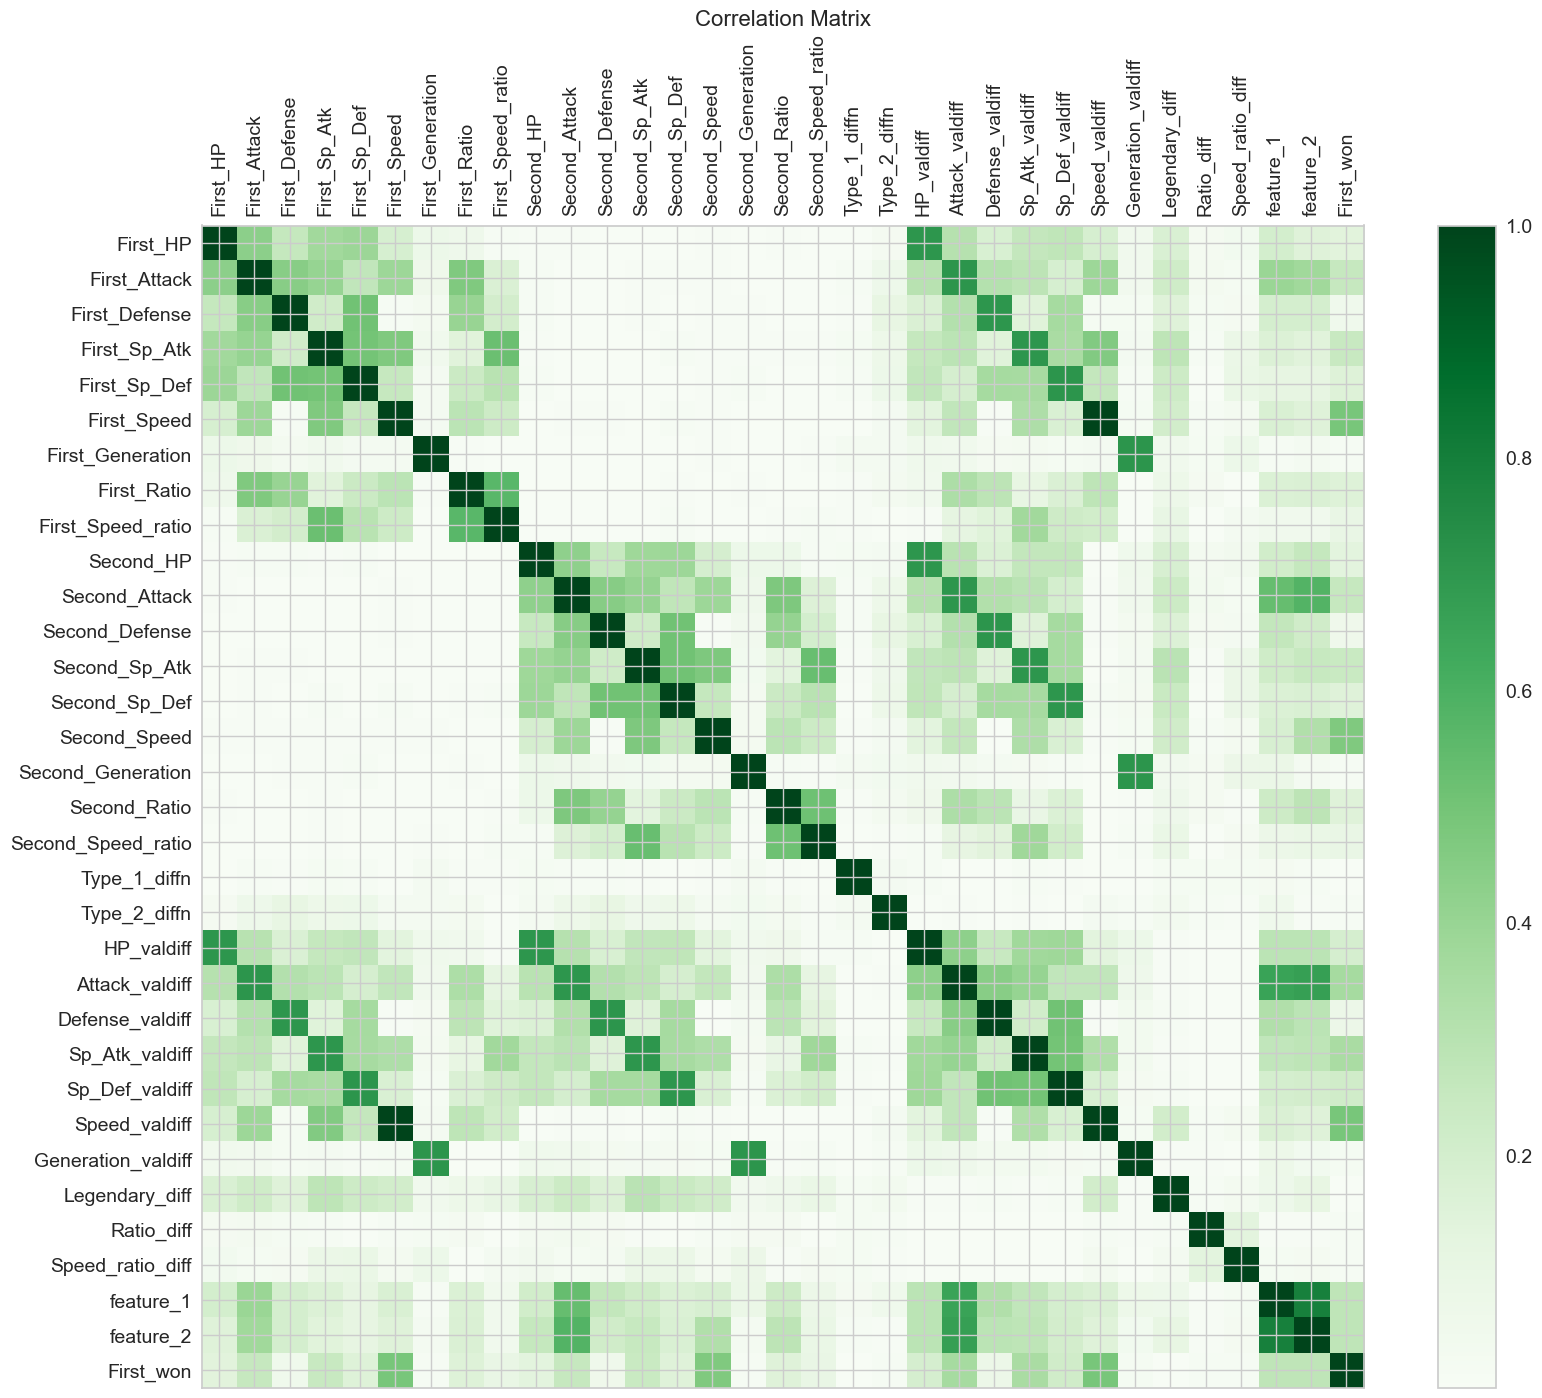

In [176]:
###################
### Correlation ###
###################

corre_data = pd.concat([X_train[num_cols],
                        pd.DataFrame(y_train)],
                       axis = 1)

cor_matrix = corre_data.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
print(to_drop)

f = plt.figure(figsize=(19, 15))
plt.matshow(cor_matrix, fignum=f.number, cmap = 'Greens')
plt.xticks(range(corre_data.select_dtypes(['number']).shape[1]),
           corre_data.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(corre_data.select_dtypes(['number']).shape[1]),
           corre_data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show();

In [177]:
#####################
### MinMax scaler ###
#####################

print(X_train[num_cols].shape)

transformer_train = MinMaxScaler().fit(X_train[num_cols])
num_data_train = pd.DataFrame(transformer_train.transform(X_train[num_cols]))
num_data_train.columns = num_cols
print(num_data_train.shape)

num_data_test = minmax_dset(X_test,num_cols) ### Test ###

print(
    f'Data min:max {num_data_train.min().min(),num_data_train.max().max()}')

(30000, 32)
(30000, 32)
(20000, 32)
Data min:max (0.0, 1.0000000000000002)


In [179]:
cat_cols = list(X_train.select_dtypes(include=['object']))
cat_cols = (list(set(cat_cols) - set([col for col in X_train.columns if '_diffn' in col])))

In [180]:
################################### 
### High cardinality adjustment ###
################################### 

card_vars = []
cat_data = X_train[cat_cols]
for i in range(cat_data.shape[1]):
    X_train.loc[X_train[cat_data.columns[i]].isnull(),cat_data.columns[i]] = 'Missing'
    X_test.loc[X_test[cat_data.columns[i]].isnull(),cat_data.columns[i]] = 'Missing'

    if (cat_data.iloc[:,i].nunique() > 60):
        print(cat_data.columns[i],len(list(set(cat_data.iloc[:,i]))))

        a = pd.crosstab(cat_data[cat_data.columns[i]],columns='Count')
        a = pd.DataFrame(a).sort_values('Count',ascending=False).reset_index()
        val_list = list(a.iloc[:20,0])
        X_train.loc[~X_train[cat_data.columns[i]].isin(val_list),cat_data.columns[i]] = 'Other'
        X_test.loc[~X_test[cat_data.columns[i]].isin(val_list),cat_data.columns[i]] = 'Other'

    if (len(list(set(cat_data.iloc[:,i]))) > 100):
        card_vars.append(cat_data.columns[i])

print(card_vars)

First_Name 784
Second_Name 784
['First_Name', 'Second_Name']


In [181]:
#pd.crosstab(cat_data_vals.First_Name, columns = 'Count')

In [182]:
########################
### One hot encoding ###
########################

ohe = OneHotEncoder()
print(X_train.shape)
# (357127, 56)

### Train ###

ohe.fit(X_train[cat_cols])
colnames = ohe.get_feature_names_out(cat_cols)

cat_data_train = ohe_dset(X_train,cat_cols)  ### Train ###

for name in list(cat_data_train.columns):
    cat_data_train[name] = cat_data_train[name].astype(int)

cat_data_test = ohe_dset(X_test,cat_cols)    ### Test ###

print(cat_data_train.shape)
cat_data_train.head()

print(
    f'Data min:max {cat_data_train.min().min(),cat_data_train.max().max()}')

(30000, 46)
(30000, 134)
(20000, 134)
(30000, 134)
Data min:max (0, 1)


In [183]:
print([col for col in X_train.columns if '_diffn' in col])
print([col for col in X_train.columns if 'feature_' in col])
bin_data_train = X_train[[col for col in X_train.columns if '_diffn' in col] + [col for col in X_train.columns if 'feature_' in col]]
bin_data_test = X_test[[col for col in X_train.columns if '_diffn' in col] + [col for col in X_train.columns if 'feature_' in col]]

['Type_1_diffn', 'Type_2_diffn']
['feature_1', 'feature_2']


In [184]:
cat_data_train = cat_data_train[(list(set(list(cat_data_train.columns)) - set(['level_0', 'index'])))]
num_data_train = num_data_train[(list(set(list(num_data_train.columns)) - set(['level_0', 'index'])))]
#ord_data_train = ord_data_train[(list(set(list(ord_data_train.columns)) - set(['level_0', 'index'])))]
bin_data_train = bin_data_train[(list(set(list(bin_data_train.columns)) - set(['level_0', 'index'])))]

cat_data_test = cat_data_test[(list(set(list(cat_data_test.columns)) - set(['level_0', 'index'])))]
num_data_test = num_data_test[(list(set(list(num_data_test.columns)) - set(['level_0', 'index'])))]
#ord_data_test = ord_data_test[(list(set(list(ord_data_test.columns)) - set(['level_0', 'index'])))]
bin_data_test = bin_data_test[(list(set(list(bin_data_test.columns)) - set(['level_0', 'index'])))]

In [185]:
print("Categorical data", list(cat_data_train.columns))
print("Numerical data", list(num_data_train.columns))
#print("Ordinal data", list(ord_data_train.columns))
print("Binned data", list(bin_data_train.columns))

Categorical data ['Second_Type_2_Fairy', 'First_Name_Minccino', 'Second_Name_Mega Steelix', 'First_Type_2_Fire', 'Second_Type_1_Electric', 'First_Type_1_Psychic', 'First_Type_2_Normal', 'Second_Type_2_Dragon', 'Second_Type_2_Poison', 'First_Type_1_Steel', 'First_Name_Mewtwo', 'Attack_diff_First_lower', 'HP_diff_First_lower', 'First_Type_2_Dragon', 'Second_Type_1_Steel', 'HP_diff_First_higher', 'First_Type_1_Fairy', 'First_Name_Illumise', 'Defense_diff_First_higher', 'Second_Type_1_Grass', 'First_Name_Tentacool', 'Sp_Atk_diff_Same', 'Second_Type_1_Ghost', 'First_Type_2_Flying', 'Second_Name_Dusknoir', 'First_Type_2_Fairy', 'Second_Name_Nidorina', 'First_Name_Joltik', 'First_Type_2_Unknown', 'Attack_diff_Same', 'First_Type_2_Steel', 'Second_Type_1_Bug', 'First_Name_Malamar', 'First_Type_1_Ground', 'Sp_Atk_diff_First_higher', 'Second_Type_2_Electric', 'Attack_diff_First_higher', 'Generation_diff_Same', 'Defense_diff_Same', 'First_Type_1_Ghost', 'Second_Name_Staryu', 'First_Type_1_Ice', 'S

In [186]:
###########################
### Bring data together ###
###########################

#print(cat_data_train.shape, num_data_train.shape, ord_data_train.shape, bin_data_train.shape)
cat_data_train = cat_data_train.reset_index()
num_data_train = num_data_train.reset_index()
#ord_data_train = ord_data_train.reset_index()
bin_data_train = bin_data_train.reset_index()

X_train_mod = pd.concat([cat_data_train,num_data_train],axis = 1)
#X_train_mod = pd.concat([X_train_mod,ord_data_train],axis = 1)
X_train_mod = pd.concat([X_train_mod,bin_data_train],axis = 1)
print(X_train_mod.shape)

#print(cat_data_test.shape, num_data_test.shape, bin_data_test.shape)
cat_data_test = cat_data_test.reset_index()
num_data_test = num_data_test.reset_index()
bin_data_test = bin_data_test.reset_index()
X_test_mod = pd.concat([cat_data_test,num_data_test],axis = 1)
#X_test_mod = pd.concat([X_test_mod,ord_data_test],axis = 1)
X_test_mod = pd.concat([X_test_mod,bin_data_test],axis = 1)

print(X_train_mod.shape, X_test_mod.shape)

(30000, 173)
(30000, 173) (20000, 173)


In [187]:
####################################################
### Check that train/test sets have same columns ###
####################################################

try:
    X_train_cols = list(set(X_train_mod.columns))
    X_train_cols.remove('index')
    X_train_mod = X_train_mod[X_train_cols]

except:
    X_train_mod = X_train_mod
    
try:
    X_train_cols = list(set(X_train_mod.columns))
    X_train_cols.remove('level_0')
    X_train_mod = X_train_mod[X_train_cols]

except:
    X_train_mod = X_train_mod

mod_cols = (list(set(list(X_train_mod.columns)) - set(['index'])))
X_train_mod = X_train_mod[mod_cols]
miss_lst = list(set(list(X_train_mod.columns)) - set(list(X_test_mod.columns)))

for name in miss_lst:
    X_test_mod[name] = 0
X_test_mod = X_test_mod[list(X_train_mod.columns)]

drop_test_lst = list(set(list(X_test_mod.columns)) - set(list(X_train_mod.columns)))
X_test_mod = X_test_mod.drop(drop_test_lst, axis = 1)


print(X_train_mod.shape, X_test_mod.shape)
# (64215, 105) (42811, 135) (10148, 107)


(30000, 170) (20000, 178)


In [188]:
a = list(X_train_mod.columns)
a.sort()
print(a)

['Attack_diff_First_higher', 'Attack_diff_First_lower', 'Attack_diff_Same', 'Attack_valdiff', 'Defense_diff_First_higher', 'Defense_diff_First_lower', 'Defense_diff_Same', 'Defense_valdiff', 'First_Attack', 'First_Defense', 'First_Generation', 'First_HP', 'First_Name_Alakazam', 'First_Name_Deoxys Defense Forme', 'First_Name_Druddigon', 'First_Name_Elgyem', 'First_Name_Illumise', 'First_Name_Jirachi', 'First_Name_Joltik', 'First_Name_Lickilicky', 'First_Name_Malamar', 'First_Name_Mega Abomasnow', 'First_Name_Metang', 'First_Name_Mewtwo', 'First_Name_Minccino', 'First_Name_Onix', 'First_Name_Other', 'First_Name_Parasect', 'First_Name_Poliwhirl', 'First_Name_Scyther', 'First_Name_Slaking', 'First_Name_Steelix', 'First_Name_Tentacool', 'First_Ratio', 'First_Sp_Atk', 'First_Sp_Def', 'First_Speed', 'First_Speed_ratio', 'First_Type_1_Bug', 'First_Type_1_Dark', 'First_Type_1_Dragon', 'First_Type_1_Electric', 'First_Type_1_Fairy', 'First_Type_1_Fighting', 'First_Type_1_Fire', 'First_Type_1_Flyi

### Models

#### Baseline

In [123]:
########################################################
### Check the performance on all the baseline models ###
########################################################

models = select_model(X_train_mod, y_train)

`use_label_encoder` is deprecated in 1.7.0.
 80%|████████  | 8/10 [03:58<01:17, 38.80s/it]`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
100%|██████████| 10/10 [05:17<00:00, 31.73s/it]


In [124]:
models.head(20)

model run_time  accuracy
0      CatBoostClassifier     1.03  0.997261
1           XGBClassifier     0.88  0.996513
2          LGBMClassifier     0.43  0.996223
3      AdaBoostClassifier     0.64  0.984164
4         RidgeClassifier     0.37  0.982905
5           SGDClassifier     0.39  0.981072
6             BernoulliNB     0.37  0.972437
9  DecisionTreeClassifier     0.42  0.957484
7     ExtraTreeClassifier     0.38  0.929326
8         DummyClassifier     0.37  0.500000

#### Catboost model

In [189]:
######################################
### CatBoost hyperparameter tuning ###
######################################

pbounds = {"n_estimators": (150,400),
           "depth": (2,7),
           "learning_rate": (0.01, 0.2),
           "subsample":(0.6, 1.0),
           "num_leaves": (16,40),
           "max_bin":(150,300),
           "l2_leaf_reg":(2,10),
           "model_size_reg": (0,10)
}
optimizer = BayesianOptimization(
    f = CB_opt,
    pbounds = pbounds,
    verbose = 2,
    random_state = 888,
)

optimizer.maximize(init_points = 15, n_iter = 25)

print(optimizer.max)


print("CV score: {:<8.5f}".format(CB_opt(int(optimizer.max['params']['n_estimators']),
                                         round(optimizer.max['params']['depth'],0),
                                         optimizer.max['params']['learning_rate'],
                                         round(optimizer.max['params']['max_bin'],0),
                                         optimizer.max['params']['subsample'],
                                         round(optimizer.max['params']['num_leaves'],0),
                                         optimizer.max['params']['l2_leaf_reg'],
                                         optimizer.max['params']['model_size_reg'])))

###########################
### Fit the tuned model ###
###########################

cboost_model_hy = CatBoostClassifier(depth = round(optimizer.max['params']['depth'],0),
                                    l2_leaf_reg = optimizer.max['params']['l2_leaf_reg'],
                                    learning_rate = optimizer.max['params']['learning_rate'],
                                    max_bin = round(optimizer.max['params']['max_bin'],0),
                                    n_estimators = int(optimizer.max['params']['n_estimators']),
                                    num_leaves = round(optimizer.max['params']['num_leaves'],0),
                                    subsample = optimizer.max['params']['subsample'],
                                    random_state = 88,
                                    grow_policy = "Lossguide",
                                    verbose = 0,
                                    eval_metric = "AUC")

# {'target': 0.9771615798816367, 'params': {'depth': 5.248248154717512, 'l2_leaf_reg': 8.807723046724721, 
#  'learning_rate': 0.18087420297633025, 'max_bin': 204.52354578410325, 'model_size_reg': 5.095688352188374, 
#  'n_estimators': 304.88488427139725, 'num_leaves': 22.39189703243624, 'subsample': 0.7831080405539596}}
# CV score: 0.97689 

|   iter    |  target   |   depth   | l2_lea... | learni... |  max_bin  | model_... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------


CatBoostError: /Users/zomb-ml-platform-msk/go-agent-21.2.0/pipelines/BuildMaster/catboost.git/catboost/libs/data/features_layout.cpp:109: All feature names should be different, but 'Type_2_diffn' used more than once.

#### LBGM model

In [ ]:
#################################
### LGBM Hyperparamter tuning ###
#################################

import lightgbm as lgb

%time

### prepare data ###

train_data = lgb.Dataset(data = X_train_mod,
                         label = y_train,
                         free_raw_data = False)

### parameters ###

lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                        'num_leaves': (24, 80),
                                        'feature_fraction': (0.1, 0.9),
                                        'bagging_fraction': (0.8, 1),
                                        'max_depth': (5, 30),
                                        'max_bin':(20,90),
                                        'min_data_in_leaf': (20, 80),
                                        'min_sum_hessian_in_leaf':(0,100),
                                        'subsample': (0.01, 1.0)},
                             random_state=200)


lgbBO.maximize(init_points = 15,
               n_iter = 25)

model_auc=[]
for model in range(len( lgbBO.res)):
    model_auc.append(lgbBO.res[model]['target'])

    # return best parameters
opt_params_lbgm = lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

opt_params_lbgm[1]["num_leaves"] = int(round(opt_params_lbgm[1]["num_leaves"]))
opt_params_lbgm[1]['max_depth'] = int(round(opt_params_lbgm[1]['max_depth']))
opt_params_lbgm[1]['min_data_in_leaf'] = int(round(opt_params_lbgm[1]['min_data_in_leaf']))
opt_params_lbgm[1]['max_bin'] = int(round(opt_params_lbgm[1]['max_bin']))
opt_params_lbgm[1]['objective']='binary'
opt_params_lbgm[1]['metric']='auc'
opt_params_lbgm[1]['is_unbalance']=True
opt_params_lbgm[1]['boost_from_average']=False
opt_params_lbgm = opt_params_lbgm[1]

print(opt_params_lbgm)

folds = StratifiedKFold(n_splits=10,
                        shuffle=True,
                        random_state=31416)
folds.get_n_splits(X_train_mod, y_train)

oof = np.zeros(len(X_train_mod))
predictions = np.zeros(len(X_test_mod))

for train_index, test_index in folds.split(X_train_mod, y_train):

    trainx, x_test_cv = X_train_mod.iloc[train_index], X_train_mod.iloc[test_index]
    trainy, y_test_cv = pd.DataFrame(y_train).iloc[train_index], pd.DataFrame(y_train).iloc[test_index]

    trn_data = lgb.Dataset(trainx,
                           label = trainy)
    val_data = lgb.Dataset(x_test_cv,
                           label = y_test_cv)

    num_round = 15000
    lbgm_model_hy = lgb.train(opt_params_lbgm,
                              trn_data,
                              num_round,
                              valid_sets = [trn_data, val_data],
                              verbose_eval = 500,
                              early_stopping_rounds = 250)

    oof[test_index] = lbgm_model_hy.predict(x_test_cv, num_iteration = lbgm_model_hy.best_iteration)

    predictions += lbgm_model_hy.predict(X_test_mod, num_iteration = lbgm_model_hy.best_iteration) / folds.n_splits
    pred_labels = np.rint(predictions)

print("CV score: {:<8.5f}".format(roc_auc_score(y_test,predictions)))

In [ ]:
###########################################
### Assess the performance of the model ###
###########################################

models_optimized = [('CatBoost_optimized', cboost_model_hy),
                    ('LGBM_optimized', lbgm_model_hy)]

dset = [('Training', X_train_mod, y_train),
        ('Test', X_test_mod, y_test)]

results_fin = pd.DataFrame(columns = ['Model','Metrics','Training','Test'])

for name, model in tqdm(models_optimized):

    results = pd.DataFrame(['ROC/AUC:','Accuracy:','F1 score:'],
                           columns = ['Metrics'])

    for name_dset, X_dset, y_dset in tqdm(dset):

        #####################
        ### Fit the model ###
        #####################

        if name != 'LGBM_optimized':

            if name_dset == 'Training':
                model.fit(X_dset, y_dset)

            y_pred_p = model.predict_proba(X_dset)
            y_pred_p1 = y_pred_p[:,1]

        y_pred_hyp = model.predict(X_dset)
        if name == 'LGBM_optimized':
            y_pred_p1 = pd.DataFrame(y_pred_hyp)
            y_pred_hyp = np.rint(y_pred_hyp)

        metric = []
        roc_auc_hyp = roc_auc_score(y_dset, y_pred_hyp)
        metric.append(roc_auc_hyp)
        accuracy_hyp = accuracy_score(y_dset, y_pred_hyp)
        metric.append(accuracy_hyp)
        f1_score_hyp = metrics.f1_score(y_dset, y_pred_hyp)
        metric.append(f1_score_hyp)

        print('ROC/AUC:', roc_auc_hyp)
        print('Accuracy:', accuracy_hyp)
        print('F1 score:', f1_score_hyp)

        print(classification_report(y_dset, y_pred_hyp))

        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(y_dset, y_pred_hyp)

        cm_as_df = cm2df(cm,['Not churn','Churn'])

        print(confusion_matrix(y_dset, y_pred_hyp))

        results = pd.concat([results,
                             pd.DataFrame(metric,
                                          columns = [name_dset])],
                            axis = 1)

        #################
        ### ROC curve ###
        #################

        fpr, tpr, _ = metrics.roc_curve(y_dset,  y_pred_p1)

        plt.plot(fpr,
                 tpr,
                 label = "AUC=" + str(round(roc_auc_hyp,2)))
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc=4)
        plt.show()

        roc_data = pd.concat([pd.DataFrame(fpr),
                              pd.DataFrame(tpr)],axis = 1)
        roc_data.columns = ['FPR','TPR']
        roc_data = roc_data.reset_index()

        ###############################
        ### Precision Recall curves ###
        ###############################

        precision, recall, thresholds = precision_recall_curve(y_dset,
                                                               y_pred_p1)

        ### calculate F1 score ###

        f1 = metrics.f1_score(y_dset, y_pred_hyp)

        ### summarize scores ###

        print('Model: f1 = %.3f roc_auc = %.3f' % (f1, roc_auc_hyp))

        ### plot the precision-recall curves ###

        no_skill = len(y_dset[y_dset == 1]) / len(y_dset)

        plt.plot([0, 1],
                 [no_skill, no_skill],
                 linestyle='--',
                 label='No Skill')
        plt.plot(recall,
                 precision,
                 marker='.',
                 label = name)
        plt.xlabel('Recall')
        plt.ylabel('Precision')

        ### show the legend ###
        plt.legend()
        plt.show()

        pr_data = pd.concat([pd.DataFrame(precision),
                              pd.DataFrame(recall)],axis = 1)
        pr_data.columns = ['Precision','Recall']
        pr_data = pr_data.reset_index()

        results['Model'] = name

    results_fin = pd.concat([results_fin,
                             results],
                            axis = 0)

### Shapley values

In [190]:
explainer = shap.TreeExplainer(lbgm_model_hy)
shap_values = explainer.shap_values(X_train_mod)

# visualize the first prediction's explanation 
shap.initjs()

NameError: name 'lbgm_model_hy' is not defined

In [191]:
shap_values = shap.TreeExplainer(lbgm_model_hy).shap_values(X_train_mod)
shap.summary_plot(shap_values, X_train_mod, plot_type="bar");

NameError: name 'lbgm_model_hy' is not defined